## Black Box Interp

### Identity Model

In [1]:
import collections
import copy
import gc
import logging
import math
import os
import pickle
import time
import re
import scipy

import sys
notebook_dir = os.getcwd()
grandparent_dir = os.path.dirname(os.path.dirname(notebook_dir))
sys.path.append(grandparent_dir)
print(sys.path)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as Fn
from tensordict import TensorDict
from pandas.plotting import table
from datetime import datetime

from core import Config
from models import GPT2, CnnKF
from data_train import set_config_params
from create_plots_with_zero_pred import tf_preds
from linalg_helpers import print_matrix
from predictors import getMats, getSims, get_test_data
from run_checkpoints import getPredsEx
from scipy import stats

#set cuda device
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#set matplotlib font to default sans-serif
plt.rcParams['font.family'] = ['DejaVu Sans']
# plt.rcParams['font.sans-serif'] = ['Arial']




['/Users/sultandaniels/anaconda3/envs/mop/lib/python312.zip', '/Users/sultandaniels/anaconda3/envs/mop/lib/python3.12', '/Users/sultandaniels/anaconda3/envs/mop/lib/python3.12/lib-dynload', '', '/Users/sultandaniels/anaconda3/envs/mop/lib/python3.12/site-packages', '/Users/sultandaniels/Documents/CS282']


/Users/sultandaniels/anaconda3/envs/mop/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Could not import netCDF4's package ==> I/O will not be available in this format
CUDA_VISIBLE_DEVICES: None
['/Users/sultandaniels/anaconda3/envs/mop/lib/python312.zip', '/Users/sultandaniels/anaconda3/envs/mop/lib/python3.12', '/Users/sultandaniels/anaconda3/envs/mop/lib/python3.12/lib-dynload', '', '/Users/sultandaniels/anaconda3/envs/mop/lib/python3.12/site-packages', '/Users/sultandaniels/Documents/CS282', '/Users/sultandaniels/Documents/CS282']
['/Users/sultandaniels/anaconda3/envs/mop/lib/python312.zip', '/Users/sultandaniels/anaconda3/envs/mop/lib/python3.12', '/Users/sultandaniels/anaconda3/envs/mop/lib/python3.12/lib-dynload', '', '/Users/sultandaniels/anaconda3/envs/mop/lib/python3.12/site-packages', '/Users/sultandaniels/Documents/CS282', '/Users/sultandaniels/Documents/CS282', '/Users/sultandaniels/Documents/CS282']
Using device: cpu


In [4]:
#downlad the model checkpoints from Hugging Face
from huggingface_hub import HfApi, snapshot_download

api = HfApi(token=os.getenv("HF_TOKEN"))

os.makedirs("../checkpoints", exist_ok=True)
snapshot_download(
    repo_id="sultan-daniels/TFs_do_KF_ICL_ident_med_GPT2_checkpoints",
    repo_type="model",
    revision="main",
    local_dir="../checkpoints",
    token=os.getenv("HF_TOKEN")
)


Fetching 63 files: 100%|██████████| 63/63 [00:01<00:00, 48.75it/s]


'/Users/sultandaniels/Documents/CS282/Project/checkpoints'

In [5]:
#download the test data from Hugging Face
from huggingface_hub import hf_hub_download

# Specify the repository ID and file path
repo_id = "sultan-daniels/TFs_do_KF_ICL_ident_med_GPT2_experiment"
filename = "data/val_ident_ident_C_state_dim_5.pkl"

os.makedirs("../data", exist_ok=True)
# Download the file
file_path = hf_hub_download(repo_id=repo_id, filename=filename, local_dir="../")

print(f"File downloaded to: {file_path}")

filename = "data/val_ident_ident_C_state_dim_5_sim_objs.pkl"

# Download the file
file_path = hf_hub_download(repo_id=repo_id, filename=filename, local_dir="../")

print(f"File downloaded to: {file_path}")

File downloaded to: ../data/val_ident_ident_C_state_dim_5.pkl
File downloaded to: ../data/val_ident_ident_C_state_dim_5_sim_objs.pkl


In [6]:
from create_plots_with_zero_pred import interleave_traces
#import the config
from core import Config
from data_train import get_entries
import pickle
import os
import numpy as np

if __name__ == "__main__":
    config = Config()

    #get val data from "../outputs/GPT2/250112_043028.07172b_multi_sys_trace_ortho_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000"
    path = "../data"

    valA = "ident" #"ident", "ortho", "gaussA" #system family for linear systems

    if valA == "ortho" or valA == "ident":
        valC = "_ident_C"
        nx = 5 #state dimension
    elif valA == "gaussA":
        valC = "_gauss_C"
        nx = 10 #state dimension

    #get the data
    config.override("val_dataset_typ", valA)
    config.override("C_dist", valC)
    config.override("nx", nx)
    config.override("late_start", None) #index of the first time step to start interleaving with. If None, will start from the beginning of the trace
    config.override("num_val_tasks", 100) #number of validation systems
    config.override("num_traces", {"train": 1, "val": 1000}) #number of validation traces per system

    config.override("multi_sys_trace", True) #use multi system traces
    config.override("needle_in_haystack", True) #make needle in haystack prompts
    #set num_sys_haystack


    config.override("late_start", False)

    config.override("paren_swap", False) # set the paren_swap in the config object

    config.override("same_tokens", False) # set the same_tokens in the config object

    config.override("irrelevant_tokens", False) # set the irrelevant_tokens in the config object

    config.override("fix_needle", False) # set the fix_needle in the config object

    config.override("opposite_ortho", False) # set the opposite_ortho in the config object

    config.override("only_beg", False) # set the only_beg in the config object



    

    val_path = path + f"/val_{valA}{valC}_state_dim_{nx}.pkl"

    print(f"Getting val data from {val_path}")
    with open(val_path, 'rb') as f:
        ys = get_entries(config, f) #get the uninterleaved validation data

    for num_sys_haystack in np.arange(1,20):

        config.override("num_sys_haystack", num_sys_haystack)
        #set num_test_traces_configs to num_sys_haystack
        config.override("num_test_traces_configs", num_sys_haystack)
        config.override("n_positions", (config.len_seg_haystack + 2)*(num_sys_haystack+1)) #number of positions in the needle in haystack prompt

        #get interleaved traces
        multi_sys_ys, sys_choices_per_config, sys_dict_per_config, tok_seg_lens_per_config, seg_starts_per_config, real_seg_lens_per_config, sys_inds_per_config = interleave_traces(config, ys, num_test_traces_configs=config.num_test_traces_configs, num_trials=config.num_traces["val"], ex=0)

        #save the outputs of interleave traces to a zipped file
        file_dict = {"multi_sys_ys": multi_sys_ys, "sys_choices_per_config": sys_choices_per_config, "sys_dict_per_config": sys_dict_per_config, "tok_seg_lens_per_config": tok_seg_lens_per_config, "seg_starts_per_config": seg_starts_per_config, "real_seg_lens_per_config": real_seg_lens_per_config, "sys_inds_per_config": sys_inds_per_config}


        filename = path + f"/interleaved_traces_{valA}{valC}_state_dim_{nx}_num_sys_haystack_{num_sys_haystack}.pkl"
        os.makedirs(os.path.dirname(filename), exist_ok=True)

        with open(filename, 'wb') as f:
            pickle.dump(file_dict, f)
        print(f"Saved interleaved traces to {filename}")

Creating new key: late_start
Creating new key: paren_swap
Creating new key: same_tokens
Creating new key: irrelevant_tokens
Creating new key: fix_needle
Creating new key: opposite_ortho
Creating new key: only_beg
Getting val data from ../data/val_ident_ident_C_state_dim_5.pkl
Saved interleaved traces to ../data/interleaved_traces_ident_ident_C_state_dim_5_num_sys_haystack_1.pkl
Saved interleaved traces to ../data/interleaved_traces_ident_ident_C_state_dim_5_num_sys_haystack_2.pkl
Saved interleaved traces to ../data/interleaved_traces_ident_ident_C_state_dim_5_num_sys_haystack_3.pkl
Saved interleaved traces to ../data/interleaved_traces_ident_ident_C_state_dim_5_num_sys_haystack_4.pkl
Saved interleaved traces to ../data/interleaved_traces_ident_ident_C_state_dim_5_num_sys_haystack_5.pkl
Saved interleaved traces to ../data/interleaved_traces_ident_ident_C_state_dim_5_num_sys_haystack_6.pkl
Saved interleaved traces to ../data/interleaved_traces_ident_ident_C_state_dim_5_num_sys_haystack_7

In [2]:
# get model ckpt

model_name = "ident"

if model_name == "ident":
    valA = "ident"
    valC = "_ident_C"
    nx = 5

ckpt_step = 17600  #100 #1500 #17600 (100 is the first checkpoint, 1500 is in the middle of training with average predictor-like behavior, 17600 is the last checkpoint where the model can perform the recall task well)

config = Config()
output_dir, ckpt_dir, experiment_name = set_config_params(config, model_name)

config.override("ckpt_path", ckpt_dir + f"../checkpoints/step={ckpt_step}.ckpt")
print(f"ckpt_path: {config.ckpt_path}")

num_gpu = len(config.devices)
batch_size = config.batch_size
print(f"Number of GPUs: {num_gpu}")
print(f"Batch size: {batch_size}")
print(f"Number of training examples: {ckpt_step*batch_size*num_gpu}")



IDENTITY MEDIUM MODEL


ckpt_path: ../checkpoints/step=17600.ckpt
Number of GPUs: 2
Batch size: 512
Number of training examples: 18022400


In [3]:
#load the model

model = GPT2.load_from_checkpoint(config.ckpt_path,
                                n_dims_in=config.n_dims_in, n_positions=config.n_positions,
                                n_dims_out=config.n_dims_out, n_embd=config.n_embd,
                                n_layer=config.n_layer, n_head=config.n_head, use_pos_emb=config.use_pos_emb, map_location=device, strict=True).eval().to(
    device)

/Users/sultandaniels/anaconda3/envs/mop/lib/python3.12/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.2.1


In [4]:
num_sys_haystack = 2

multi_sys_ys, seg_starts_per_config, sys_inds_per_config, sys_dict_per_config, sys_choices_per_config = get_test_data(config, num_sys_haystack, valA, valC, nx)

In [6]:
trace_config = 0
trial = 0
print(f"multi_sys_ys[{trace_config},{trial}].shape: {multi_sys_ys[trace_config,trial].shape}")

sys_inds = sys_inds_per_config[trace_config]
print(f"sys_inds: {sys_inds}")
sys_dict = sys_dict_per_config[trace_config]
print(f"sys_dict: {sys_dict}")
sys_choices = sys_choices_per_config[trace_config]
print(f"sys_choices: {sys_choices}")

final_sys_name = sys_dict[sys_choices[-1]]
print(f"final_sys_name: {final_sys_name}")


final_open_ind = seg_starts_per_config[trace_config][-1]
print(f"final_open_ind: {final_open_ind}")


inserted_payload = None

multi_sys_ys[0,0].shape: (37, 57)
sys_inds: [0 1]
sys_dict: {0: 21, 1: 24}
sys_choices: [0, 1, 0]
final_sys_name: 21
final_open_ind: 25


In [7]:
preds_tf = tf_preds(multi_sys_ys, model, device, config)
num_sys = np.size(seg_starts_per_config[trace_config])-1
q_ind = seg_starts_per_config[trace_config][num_sys] + 1
transformer_1af = preds_tf[trace_config, :, q_ind] 
print(f"transformer_1af: {transformer_1af}")

transformer_1af: [[ 0.3697156  -0.49791998  0.3444755  -0.9026997   0.6383382 ]
 [ 0.2913082   0.62999463 -0.05289065  0.72549915 -0.3551314 ]
 [ 0.5155766  -0.20806827 -0.38380086 -0.069454    0.26574734]
 ...
 [-1.7330234  -0.18996972 -0.57922417 -0.5149467  -0.15318955]
 [-0.23356816  0.56198007  0.45894086 -0.8418864  -0.02750861]
 [-0.4543092  -1.0013466   0.16059934  0.4050195   0.9345814 ]]


In [8]:
alpha = 1.0 #1e-2 #0.0 #0.5e-1
alpha_string = f"alpha_{alpha}"
payload_experiment = f"wrong_payload_{alpha_string}" #f"correct_payload_{alpha_string}" #f"wrong_payload_{alpha_string}"
if "random" in payload_experiment:

    #generate a 5d multivariate normal distribution with cov = (1/5)*I

    mean = np.zeros(nx)
    cov = (alpha/nx)*np.eye(nx)
    num_samples = multi_sys_ys.shape[1]
    print(f"num_samples: {num_samples}")
    random_payload = np.random.multivariate_normal(mean, cov, 1)
    print(f"random_payload.shape: {random_payload.shape}")
    #copy the random payload num_samples times
    random_payload = np.tile(random_payload, (num_samples, 1))
    print(f"random_payload.shape: {random_payload.shape}")

    multi_sys_ys[0,:, final_open_ind, -5:] = random_payload
    multi_sys_ys[0,:, final_open_ind, int(2*final_sys_name)] = np.sqrt(2-alpha)
    
    if alpha > 0.0:
        inserted_payload = random_payload

elif "correct" in payload_experiment:

# print(f"multi_sys_ys.shape: {multi_sys_ys.shape}")


# Set last 5 elements to the correct values adjust values such that the squared norm is 2

    num_sys = np.size(seg_starts_per_config[trace_config])-1
    q_ind = seg_starts_per_config[trace_config][num_sys] + 1
    true_1af = multi_sys_ys[trace_config, :, q_ind, -5:]
    print(f"true_1af.shape: {true_1af.shape}")
    true_1af_norm = np.linalg.norm(true_1af, axis = 1)
    # print(f"true_1af_norm[:, None]: {true_1af_norm[:, None]}")
    correct_payload = np.sqrt(alpha)*true_1af  #/true_1af_norm[:, None]
    multi_sys_ys[trace_config, :, final_open_ind, -5:] = correct_payload
    multi_sys_ys[trace_config, :, final_open_ind, int(2*final_sys_name)] = np.sqrt(2-alpha)

    if alpha > 0.0:
        inserted_payload = correct_payload

elif "wrong" in payload_experiment:
    # Set last 5 elements to the incorrect values adjust values such that the squared norm is 2
    num_sys = np.size(seg_starts_per_config[trace_config])-1
    q_ind = np.random.choice(seg_starts_per_config[trace_config][1:-1]) + 1
    true_1af = multi_sys_ys[trace_config, :, q_ind, -5:]
    print(f"true_1af: {true_1af}")
    true_1af_norm = np.linalg.norm(true_1af, axis = 1)
    wrong_payload = np.sqrt(alpha)*true_1af  #/true_1af_norm[:, None]
    multi_sys_ys[trace_config, :, final_open_ind, -5:] = wrong_payload
    multi_sys_ys[trace_config, :, final_open_ind, int(2*final_sys_name)] = np.sqrt(2-alpha)

    print(f"wrong_payload[0,:]: {wrong_payload[0,:]}")

    if alpha > 0.0:
        inserted_payload = wrong_payload


print(f"q_ind: {q_ind}")

true_1af: [[-0.18110178 -0.36997807 -0.1198192   0.24733157 -0.25806037]
 [ 0.1874331  -0.5540929  -0.31284472 -0.40496132 -0.09262767]
 [-0.684093   -0.64290714  0.11447282 -0.01957697  0.81273586]
 ...
 [ 0.3847541  -0.07916063 -0.60480183 -0.3455443   0.24466352]
 [-0.18175007  0.61415404 -0.5428163   0.90583754 -0.23799247]
 [ 0.63206255 -0.19609356 -0.32516    -0.04335836 -0.5164438 ]]
wrong_payload[0,:]: [-0.18110178 -0.36997807 -0.1198192   0.24733157 -0.25806037]
q_ind: 14


In [9]:
def alphaExperiment(alpha, multi_sys_ys, model, device, pay_flag, debug=False):
    alpha_string = f"alpha_{alpha}"
    payload_experiment = f"{pay_flag}_payload_{alpha_string}" #f"correct_payload_{alpha_string}" #f"wrong_payload_{alpha_string}"
    if "random" in payload_experiment:

        #generate a 5d multivariate normal distribution with cov = (1/5)*I

        mean = np.zeros(nx)
        cov = (alpha/nx)*np.eye(nx)
        num_samples = multi_sys_ys.shape[1]
        if debug:
            print(f"num_samples: {num_samples}")
        random_payload = np.random.multivariate_normal(mean, cov, 1)
        if debug:
            print(f"random_payload.shape: {random_payload.shape}")
        #copy the random payload num_samples times
        random_payload = np.tile(random_payload, (num_samples, 1))
        if debug:
            print(f"random_payload.shape: {random_payload.shape}")

        multi_sys_ys[0,:, final_open_ind, -5:] = random_payload
        multi_sys_ys[0,:, final_open_ind, int(2*final_sys_name)] = np.sqrt(2-alpha)
        
        if alpha > 0.0:
            inserted_payload = random_payload

    elif "correct" in payload_experiment:

    # print(f"multi_sys_ys.shape: {multi_sys_ys.shape}")


    # Set last 5 elements to the correct values adjust values such that the squared norm is 2

        num_sys = np.size(seg_starts_per_config[trace_config])-1
        q_ind = seg_starts_per_config[trace_config][num_sys] + 1
        true_1af = multi_sys_ys[trace_config, :, q_ind, -5:]
        if debug:
            print(f"true_1af.shape: {true_1af.shape}")
        true_1af_norm = np.linalg.norm(true_1af, axis = 1)
        # print(f"true_1af_norm[:, None]: {true_1af_norm[:, None]}")
        correct_payload = np.sqrt(alpha)*true_1af  #/true_1af_norm[:, None]
        multi_sys_ys[trace_config, :, final_open_ind, -5:] = correct_payload
        multi_sys_ys[trace_config, :, final_open_ind, int(2*final_sys_name)] = np.sqrt(2-alpha)

        if alpha > 0.0:
            inserted_payload = correct_payload

    elif "wrong" in payload_experiment:
        # Set last 5 elements to the incorrect values adjust values such that the squared norm is 2
        num_sys = np.size(seg_starts_per_config[trace_config])-1
        q_ind = np.random.choice(seg_starts_per_config[trace_config][1:-1]) + 1
        true_1af = multi_sys_ys[trace_config, :, q_ind, -5:]
        if debug:
            print(f"true_1af: {true_1af}")
        true_1af_norm = np.linalg.norm(true_1af, axis = 1)
        wrong_payload = np.sqrt(alpha)*true_1af  #/true_1af_norm[:, None]
        multi_sys_ys[trace_config, :, final_open_ind, -5:] = wrong_payload
        multi_sys_ys[trace_config, :, final_open_ind, int(2*final_sys_name)] = np.sqrt(2-alpha)

        if debug:
            print(f"wrong_payload[0,:]: {wrong_payload[0,:]}")

        if alpha > 0.0:
            inserted_payload = wrong_payload

    elif "negative" in payload_experiment:
        num_sys = np.size(seg_starts_per_config[trace_config])-1
        q_ind = seg_starts_per_config[trace_config][num_sys] + 1
        true_1af = multi_sys_ys[trace_config, :, q_ind, -5:]
        if debug:
            print(f"true_1af.shape: {true_1af.shape}")
        true_1af_norm = np.linalg.norm(true_1af, axis = 1)
        correct_payload = np.sqrt(alpha)*true_1af
        multi_sys_ys[trace_config, :, final_open_ind, -5:] = -correct_payload
        multi_sys_ys[trace_config, :, final_open_ind, int(2*final_sys_name)] = np.sqrt(2-alpha)

        if alpha > 0.0:
            inserted_payload = -correct_payload

    else:
        print("INVALID PAYLOAD TYPE")

    if debug:
        print(f"q_ind: {q_ind}")

    return multi_sys_ys, inserted_payload

In [10]:
trace_config = 0

preds_tf = tf_preds(multi_sys_ys, model, device, config)

tf1af, true1af, avg1af, avg_w_zero1af = getMats(trace_config, seg_starts_per_config, multi_sys_ys, preds_tf)

In [ ]:
alpha_lst = np.linspace(start = 1e-3, stop = 1, num = 100)
# alpha_lst = [0.5]
#npFunc = lambda x: np.mean(scipy.stats.mode(x))
npFunc = np.median
# npFunc = scipy.stats.mode
pay_lst = ["random", "correct", "wrong", "negative"]

fig, ax = plt.subplots(4, 2, figsize=(4*4, 8*2))

p = 0
ax_count = 0
for pay_flag in pay_lst:

  stats = np.zeros((2, 4, len(alpha_lst))) # array containing averaged modes of each system modified by the alpha in alpha_lst
  for i, alpha in enumerate(alpha_lst):
    if alpha == 0.0:
      continue
    # print(f"alpha: {alpha}")
    multi_sys_ys, inserted_payload = alphaExperiment(alpha, multi_sys_ys, model, device, pay_flag, debug=False)
    preds_tf = tf_preds(multi_sys_ys, model, device, config)

    tf1af, true1af, avg1af, avg_w_zero1af = getMats(trace_config, seg_starts_per_config, multi_sys_ys, preds_tf)
    mags, angs = getSims(tf1af, true1af, avg1af, avg_w_zero1af, inserted_payload)
    # print(f"mags.key(): {mags.keys()}")

    stats[0][0][i] = npFunc(mags["true"])
    stats[0][1][i] = npFunc(mags["avg"])
    stats[0][2][i] = npFunc(mags["avg_w_zero"])
    stats[0][3][i] = npFunc(mags["payload"])

    stats[1][0][i] = npFunc(np.arccos(angs["true"])*180/np.pi)
    stats[1][1][i] = npFunc(np.arccos(angs["avg"])*180/np.pi)
    stats[1][2][i] = npFunc(np.arccos(angs["avg_w_zero"])*180/np.pi)
    stats[1][3][i] = npFunc(np.arccos(angs["payload"])*180/np.pi)



  print(f"\n\np%2 + math.floor(p/4): {p % 2 + 2*math.floor(p/4)}, math.floor(p/2) % 2: {math.floor(p/2) % 2}\n\n")
  ax[p % 2 + 2*math.floor(p/4)][math.floor(p/2) % 2].plot(alpha_lst, stats[0][0], label = "true", marker = "o", markersize=1.2)
  ax[p % 2 + 2*math.floor(p/4)][math.floor(p/2) % 2].plot(alpha_lst, stats[0][1], label = "avg", marker = "o", markersize=1.2)
  ax[p % 2 + 2*math.floor(p/4)][math.floor(p/2) % 2].plot(alpha_lst, stats[0][2], label = "avg_w_zero", marker = "o", markersize=1.2)
  ax[p % 2 + 2*math.floor(p/4)][math.floor(p/2) % 2].plot(alpha_lst, stats[0][3], label = "payload", marker = "o", markersize=1.2)
  ax[p % 2 + 2*math.floor(p/4)][math.floor(p/2) % 2].set_ylabel("Magnitudes")
  #set the x_label to be \alpha in latex
  ax[p % 2 + 2*math.floor(p/4)][math.floor(p/2) % 2].set_xlabel(r"$\alpha$", fontsize=12)
  # ax[0][p].set_xlabel("Alpha")
  
  ax[p % 2 + 2*math.floor(p/4)][math.floor(p/2) % 2].legend()

  if p % 2 == 0:

    #capitalize the first letter of the pay_flag
    pay_flag = pay_flag.capitalize()
    ax[p % 2 + 2*math.floor(p/4)][math.floor(p/2) % 2].set_title(f"{pay_flag}")

  p += 1
  
  print(f"\n\np%2 + math.floor(p/4): {p % 2 + 2*math.floor(p/4)}, math.floor(p/2) % 2: {math.floor(p/2) % 2}\n\n")

  ax_count += 1
  ax[p % 2 + 2*math.floor(p/4)][math.floor(p/2) % 2].plot(alpha_lst, stats[1][0], label = "true", marker = "o", markersize=1.2)
  ax[p % 2 + 2*math.floor(p/4)][math.floor(p/2) % 2].plot(alpha_lst, stats[1][1], label = "avg", marker = "o", markersize=1.2)
  ax[p % 2 + 2*math.floor(p/4)][math.floor(p/2) % 2].plot(alpha_lst, stats[1][2], label = "avg_w_zero", marker = "o", markersize=1.2)
  ax[p % 2 + 2*math.floor(p/4)][math.floor(p/2) % 2].plot(alpha_lst, stats[1][3], label = "payload", marker = "o", markersize=1.2)
  ax[p % 2 + 2*math.floor(p/4)][math.floor(p/2) % 2].set_ylabel("Angles")
  # ax[1][p].set_xlabel("Alpha")
  ax[p % 2 + 2*math.floor(p/4)][math.floor(p/2) % 2].set_xlabel(r"$\alpha$", fontsize=12)
  ax[p % 2 + 2*math.floor(p/4)][math.floor(p/2) % 2].legend()
  ax_count += 1
  p += 1

fig.tight_layout()
plot_path = f"../../../outputs/interp/black_box/plots/{model_name}/payload/"
os.makedirs(plot_path, exist_ok=True)
fig.savefig(f"{plot_path}payload_patch_ckpt_{ckpt_step}.pdf", bbox_inches='tight', format='pdf')

## Plot TF Mag vs Train Ex

In [52]:
num_sys_haystack = 2
trace_config = 0
multi_sys_ys, seg_starts_per_config, sys_inds_per_config, sys_dict_per_config, sys_choices_per_config = get_test_data(config, num_sys_haystack, valA, valC, nx)
model_preds, train_ex, mags_ckpts, angs_ckpts = getPredsEx(device, multi_sys_ys, seg_starts_per_config, nx, num_sys_haystack, trace_config, model_name, 17600, debug=True)



IDENTITY MEDIUM MODEL


Ckpt path /data/shared/ICL_Kalman_Experiments/model_checkpoints/GPT2/250124_052617.8dd0f8_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/checkpoints/step=100.ckpt found.
Checkpoint Path: /data/shared/ICL_Kalman_Experiments/model_checkpoints/GPT2/250124_052617.8dd0f8_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/checkpoints/step=100.ckpt
Output Directory: ../outputs/GPT2/250124_052617.8dd0f8_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000
Checkpoint Directory: /data/shared/ICL_Kalman_Experiments/model_checkpoints/GPT2/250124_052617.8dd0f8_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000
Batch size: 512
Number of GPUs: 2
Number of training examples: 102400
model: GPT2(
  (_read_in): Linear(in_features=57, out_features=128, bias=True)
  (_backbone): GPT2Model(
    (wte): Embedding(50257, 128)
    (wpe): Embe

In [7]:
print(f"model_preds.shape: {model_preds.shape}")


model_preds.shape: (61, 2, 1000, 37, 5)


model_preds: -0.018595807254314423 model_preds next: 0.37577128410339355
tf1af[0,0,0,0,0]: -0.018595807254314423, tf1af[1,0,0,]: -0.04100313037633896
tf1af: [[[-1.85958073e-02 -8.25071558e-02 -1.05168737e-01 -5.12197949e-02
   -1.58621356e-01]
  [-1.91989318e-02 -5.78869507e-02 -1.08181931e-01 -2.99088843e-02
   -1.61888421e-01]
  [-3.04835960e-02 -8.21463540e-02 -1.13473527e-01 -3.32145914e-02
   -1.31530941e-01]
  ...
  [-6.74029067e-02 -6.92742169e-02 -1.38791442e-01 -6.16241619e-02
   -1.65388435e-01]
  [-4.45204303e-02 -2.26157717e-02 -1.07245214e-01 -3.64160202e-02
   -1.74771994e-01]
  [-2.43427530e-02 -8.90704691e-02 -1.16323136e-01 -2.29597725e-02
   -1.59808353e-01]]

 [[-4.10031304e-02 -5.74915186e-02 -2.13280246e-02 -4.25170437e-02
   -3.64971235e-02]
  [-3.83764282e-02 -3.50052565e-02 -2.60103270e-02 -2.09926292e-02
   -4.15106155e-02]
  [-5.36344275e-02 -5.59120476e-02 -2.56751925e-02 -2.54265927e-02
   -1.33438520e-02]
  ...
  [-8.94782320e-02 -4.34985161e-02 -5.08808047

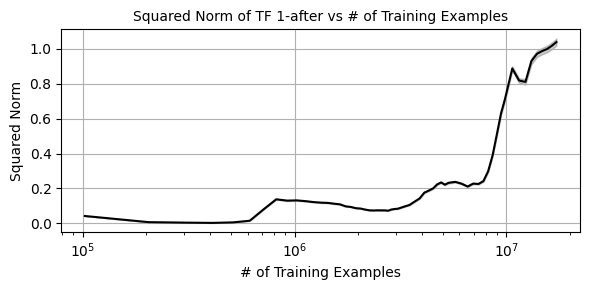

In [57]:
# tf1after
plot_path = f"../../../outputs/interp/black_box/plots/{model_name}/training_examples/"
os.makedirs(plot_path, exist_ok=True)

trace_config = 0
q_ind = seg_starts_per_config[trace_config][-1] + 1
print(f"model_preds: {model_preds[0,0,0,q_ind,0]} model_preds next: {model_preds[60,0,0,q_ind,0]}")
# print(f"q_ind: {q_ind}")

tf1af = model_preds[:,trace_config, :, q_ind, :]
print(f"tf1af[0,0,0,0,0]: {tf1af[0,0,0]}, tf1af[1,0,0,]: {tf1af[1,0,0]}")
print(f"tf1af: {tf1af}")
tf1af_norm_square = np.linalg.norm(tf1af, axis = -1)**2
print(f"tf1af_norm_square: {tf1af_norm_square}")
# print(f"tf1af_norm_square.shape: {tf1af_norm_square.shape}")
# norm_mean = np.mean(tf1af_norm_square, axis = 1)
# print(f"norm_median.shape: {norm_median.shape}")
# print(f"norm_median: {norm_median}")
#get mean and std of tf1af_norm_square
norm_mean = np.mean(tf1af_norm_square, axis = 1)
norm_std = np.std(tf1af_norm_square, axis = 1)/np.sqrt(tf1af_norm_square.shape[1])

fig,ax = plt.subplots(figsize=(6, 3))
ax.plot(train_ex, norm_mean, color = "black", label="TF")
ax.set_ylabel("Squared Norm")
ax.set_xlabel("# of Training Examples")
ax.set_xscale("log")
ax.fill_between(train_ex, norm_mean-norm_std, norm_mean+norm_std, alpha=0.2, color="black")
ax.grid()
ax.set_title(f"Squared Norm of TF 1-after vs # of Training Examples", fontsize=10)
fig.tight_layout()

fig.savefig(f"{plot_path}tf1af_norm_square.pdf", bbox_inches='tight', format='pdf')




## Plot TF Ang to True vs Train Ex

In [59]:
true_angs = []
for i in range(len(angs_ckpts)):
    true_angs.append(np.arccos(angs_ckpts[i]["true"])*180/np.pi)

print(f"true_angs[0]: {true_angs[0][0]}")
print(f"np.arcos(true_angs[0][0]): {np.arccos(true_angs[0][0])}")
print(f"len(true_angs): {len(true_angs)}")
true_angs = np.array(true_angs)

true_angs[0]: 102.20734405517578
np.arcos(true_angs[0][0]): nan
len(true_angs): 61


/tmp/ipykernel_1147892/1046217883.py:6: RuntimeWarning: invalid value encountered in arccos
  print(f"np.arcos(true_angs[0][0]): {np.arccos(true_angs[0][0])}")


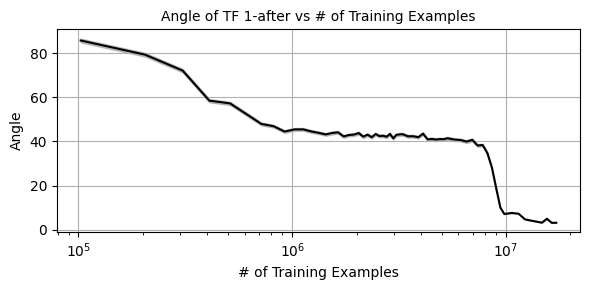

In [60]:
mean_angs = np.mean(true_angs, axis = 1)
std_angs = np.std(true_angs, axis = 1)/np.sqrt(true_angs.shape[1])
fig,ax = plt.subplots(figsize=(6, 3))
ax.plot(train_ex, mean_angs, color = "black", label="TF angle from True")
ax.fill_between(train_ex, mean_angs-std_angs, mean_angs+std_angs, alpha=0.2, color="black")
ax.set_ylabel("Angle")
ax.set_xlabel("# of Training Examples")
ax.set_xscale("log")
ax.set_title(f"Angle of TF 1-after vs # of Training Examples", fontsize=10)
fig.tight_layout()
ax.grid()
fig.savefig(f"{plot_path}tf1af_angle.pdf", bbox_inches='tight', format='pdf')

### Perform "Logit Lens" on model activations at each layer

In [ ]:
print(f"model: {model}")

NameError: name 'model' is not defined

In [48]:
ckpt_step = 17600 #17600 #100 #1500
# del model_avg
gc.collect()

config = Config()
output_dir, ckpt_dir, experiment_name = set_config_params(config, model_name)

config.override("ckpt_path", ckpt_dir + f"/checkpoints/step={ckpt_step}.ckpt")

model_avg = GPT2.load_from_checkpoint(config.ckpt_path,
                                n_dims_in=config.n_dims_in, n_positions=config.n_positions,
                                n_dims_out=config.n_dims_out, n_embd=config.n_embd,
                                n_layer=config.n_layer, n_head=config.n_head, use_pos_emb=config.use_pos_emb, map_location=device, strict=True, output_hidden_states=True).eval().to(device)

print(f"config.ckpt_path: {config.ckpt_path}")
print(f"model: {model_avg}")



IDENTITY MEDIUM MODEL


config.ckpt_path: /data/shared/ICL_Kalman_Experiments/model_checkpoints/GPT2/250124_052617.8dd0f8_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/checkpoints/step=17600.ckpt
model: GPT2(
  (_read_in): Linear(in_features=57, out_features=128, bias=True)
  (_backbone): GPT2Model(
    (wte): Embedding(50257, 128)
    (wpe): Embedding(2048, 128)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=384, nx=128)
          (c_proj): Conv1D(nf=128, nx=128)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=512, nx=128)
          (c_proj): Conv1D(nf=128, nx=512)
          

In [49]:
num_sys_haystack = 2
trace_config = 0
multi_sys_ys, seg_starts_per_config, sys_inds_per_config, sys_dict_per_config, sys_choices_per_config = get_test_data(config, num_sys_haystack, valA, valC, nx)

q_ind = seg_starts_per_config[trace_config][-1] + 1
print(f"q_ind: {q_ind}")

print(f"config.ckpt_path: {config.ckpt_path}")

print(type(multi_sys_ys))
print(f"config.ckpt_path: {config.ckpt_path}")
# multi_sys_ys = np.expand_dims(multi_sys_ys[0,0,:,:], axis=(0,1))
forward_multi_sys_ys = multi_sys_ys[:,:,:-1,:].reshape(multi_sys_ys.shape[0]*multi_sys_ys.shape[1], multi_sys_ys.shape[2]-1, multi_sys_ys.shape[3])
print(f"multi_sys_ys.shape: {multi_sys_ys.shape}")
print(f"forward_multi_sys_ys.shape: {forward_multi_sys_ys.shape}")

inp = model_avg._read_in(torch.from_numpy(forward_multi_sys_ys).to(device))
print(f"inp.shape: {inp.shape}")
out = model_avg._backbone(inputs_embeds=inp)
print(f"out.shape: {out}")
all_hidden_states = out.hidden_states
print(f"all_hidden_states[0]: {all_hidden_states[0]}")
print(f"inp: {inp}")
last_hidden_state = all_hidden_states[-1]
print(f"last_hidden_state: {last_hidden_state}")
final_out = model_avg._read_out(last_hidden_state)
print(f"final_out: {final_out[:,q_ind-1,:]}")


preds_tf_ebonye = tf_preds(multi_sys_ys, model_avg, device, config)
print(f"preds_tf_ebonye[:,:,q_ind,:]: {preds_tf_ebonye[:,:,q_ind,:]}")


q_ind: 26
config.ckpt_path: /data/shared/ICL_Kalman_Experiments/model_checkpoints/GPT2/250124_052617.8dd0f8_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/checkpoints/step=17600.ckpt
<class 'numpy.ndarray'>
config.ckpt_path: /data/shared/ICL_Kalman_Experiments/model_checkpoints/GPT2/250124_052617.8dd0f8_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/checkpoints/step=17600.ckpt
multi_sys_ys.shape: (2, 1000, 37, 57)
forward_multi_sys_ys.shape: (2000, 36, 57)
inp.shape: torch.Size([2000, 36, 128])
out.shape: BaseModelOutputWithPastAndCrossAttentions(last_hidden_state=tensor([[[-1.3181,  0.5475,  1.1689,  ...,  1.0578,  0.9416, -0.9881],
         [-0.2193, -0.4175, -1.7272,  ..., -1.6168,  0.0268, -1.1409],
         [ 1.0728, -0.5362, -1.4028,  ..., -1.0617, -0.5255,  0.6580],
         ...,
         [ 1.2103, -0.5446, -1.2175,  ..., -1.0975, -0.4776,  0.8045],
         [ 1.2461, -0.4992, -1.1955,  ..., -1.0381,

In [50]:
lenses = []
for i in range(len(all_hidden_states)):
    if i < len(all_hidden_states)-1:
        normed_state = model_avg._backbone.ln_f(all_hidden_states[i])
    else:
        normed_state = all_hidden_states[i]
    lens = model_avg._read_out(normed_state).detach().cpu().numpy()
    zer = np.zeros_like(lens[:,0:1,:])
    print(f"zer.shape: {zer.shape}")
    lens = np.concatenate((zer, lens), axis=1)
    lens = lens.reshape(multi_sys_ys.shape[0], multi_sys_ys.shape[1], multi_sys_ys.shape[2], lens.shape[-1])
    print(f"lens.shape: {lens.shape}")
    lenses.append(lens)



zer.shape: (2000, 1, 5)
lens.shape: (2, 1000, 37, 5)
zer.shape: (2000, 1, 5)
lens.shape: (2, 1000, 37, 5)
zer.shape: (2000, 1, 5)
lens.shape: (2, 1000, 37, 5)
zer.shape: (2000, 1, 5)
lens.shape: (2, 1000, 37, 5)
zer.shape: (2000, 1, 5)
lens.shape: (2, 1000, 37, 5)
zer.shape: (2000, 1, 5)
lens.shape: (2, 1000, 37, 5)
zer.shape: (2000, 1, 5)
lens.shape: (2, 1000, 37, 5)
zer.shape: (2000, 1, 5)
lens.shape: (2, 1000, 37, 5)
zer.shape: (2000, 1, 5)
lens.shape: (2, 1000, 37, 5)
zer.shape: (2000, 1, 5)
lens.shape: (2, 1000, 37, 5)
zer.shape: (2000, 1, 5)
lens.shape: (2, 1000, 37, 5)
zer.shape: (2000, 1, 5)
lens.shape: (2, 1000, 37, 5)
zer.shape: (2000, 1, 5)
lens.shape: (2, 1000, 37, 5)





BLOCK 0



transformer_1af [[ 0.5023557   0.584168   -0.0377318   0.71842766 -0.64963984]
 [ 0.5023557   0.584168   -0.0377318   0.71842766 -0.64963984]
 [ 0.5023557   0.584168   -0.0377318   0.71842766 -0.64963984]
 ...
 [ 0.5023557   0.584168   -0.0377318   0.71842766 -0.64963984]
 [ 0.5023557   0.584168   -0.0377318   0.71842766 -0.64963984]
 [ 0.5023557   0.584168   -0.0377318   0.71842766 -0.64963984]]


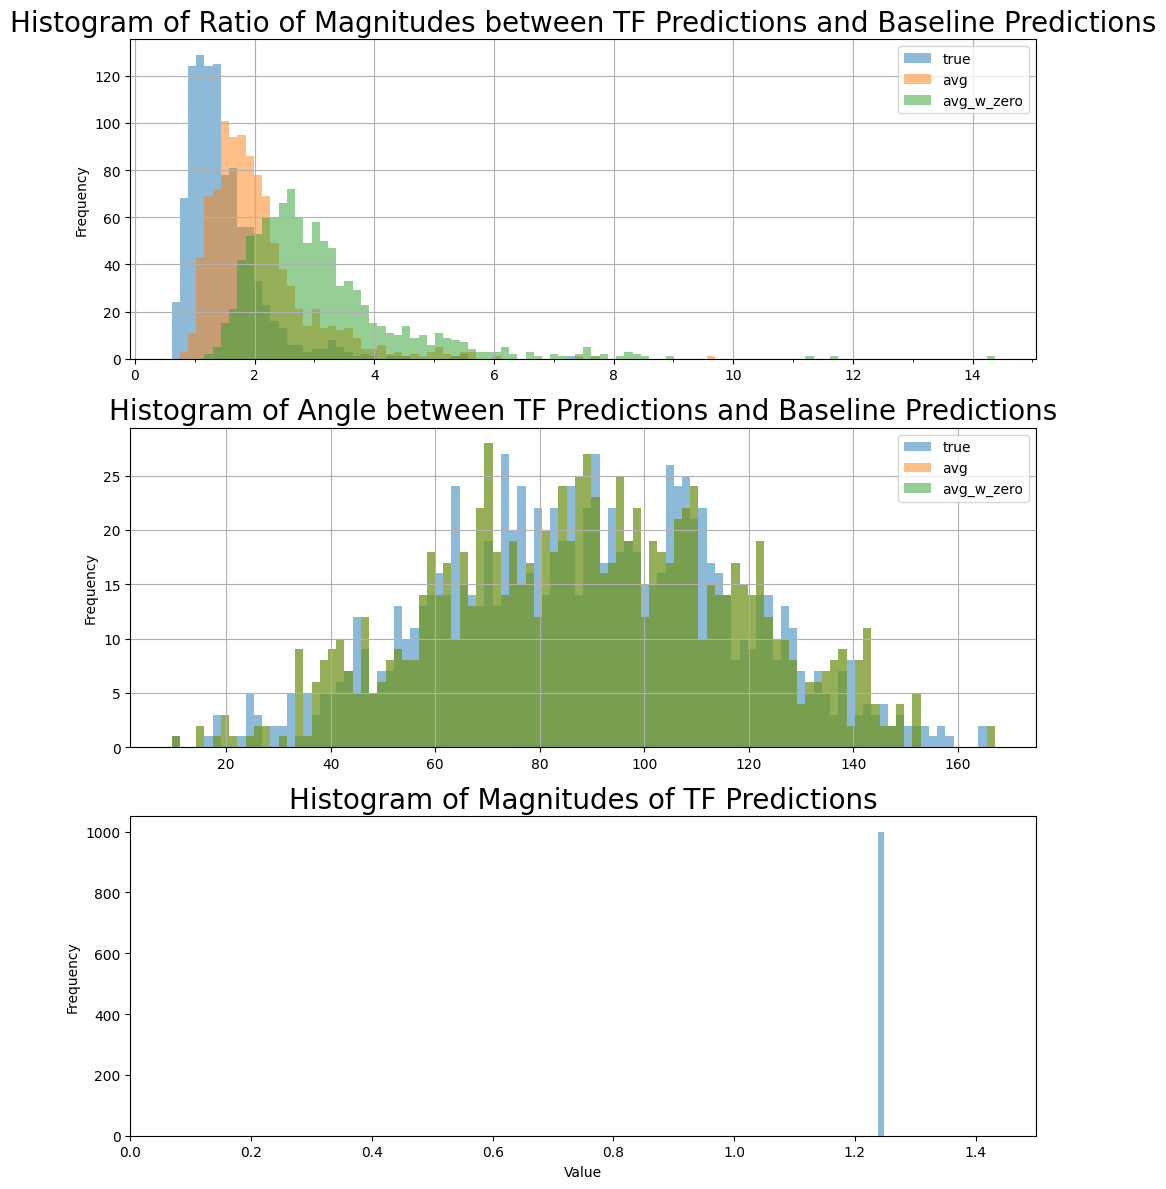




BLOCK 1



transformer_1af [[ 0.19722696  0.5343819  -0.31579715  0.6947679  -0.33256584]
 [ 0.24336159  0.5419067  -0.29050988  0.6849554  -0.48317054]
 [ 0.25166693  0.52040446 -0.26090556  0.658142   -0.35000417]
 ...
 [ 0.36415243  0.49835145 -0.22032645  0.68334043 -0.43511742]
 [ 0.37213546  0.5117552  -0.28440875  0.7006134  -0.49442157]
 [ 0.20373377  0.5647375  -0.26635844  0.631729   -0.34590214]]


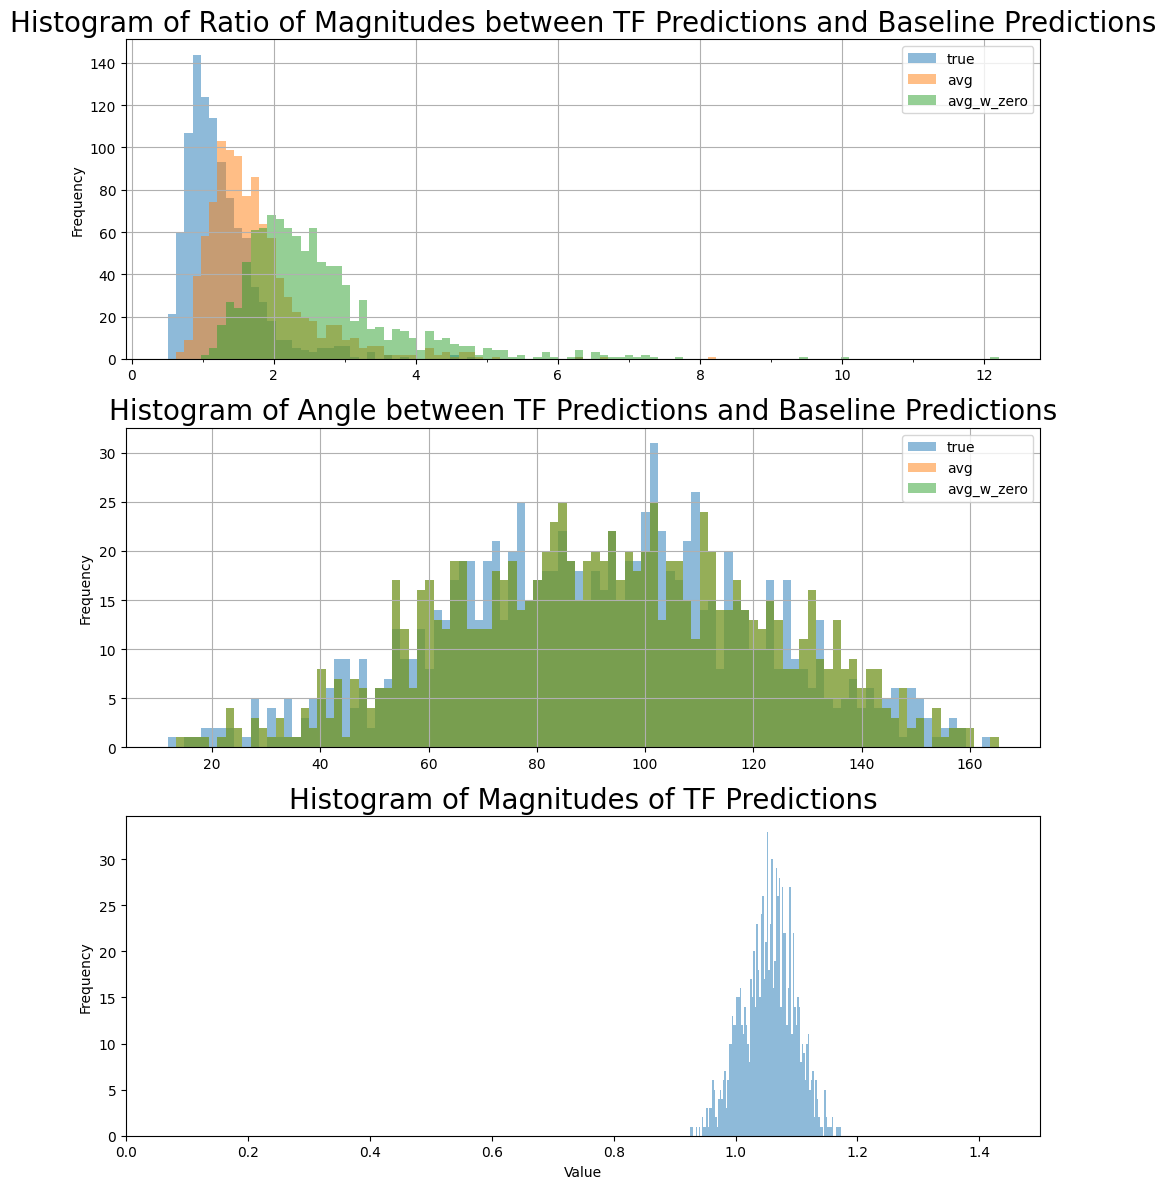




BLOCK 2



transformer_1af [[ 0.2504979   0.6084846  -0.36520267  0.4808994  -0.27948675]
 [ 0.21629563  0.5981124  -0.33765745  0.47678646 -0.3613483 ]
 [ 0.2815572   0.59788746 -0.35335642  0.46201548 -0.27338517]
 ...
 [ 0.32419637  0.5802953  -0.27933115  0.48536444 -0.3423896 ]
 [ 0.3835284   0.58269775 -0.3279216   0.45394278 -0.38007128]
 [ 0.2028251   0.6059731  -0.29904887  0.45218366 -0.31281966]]


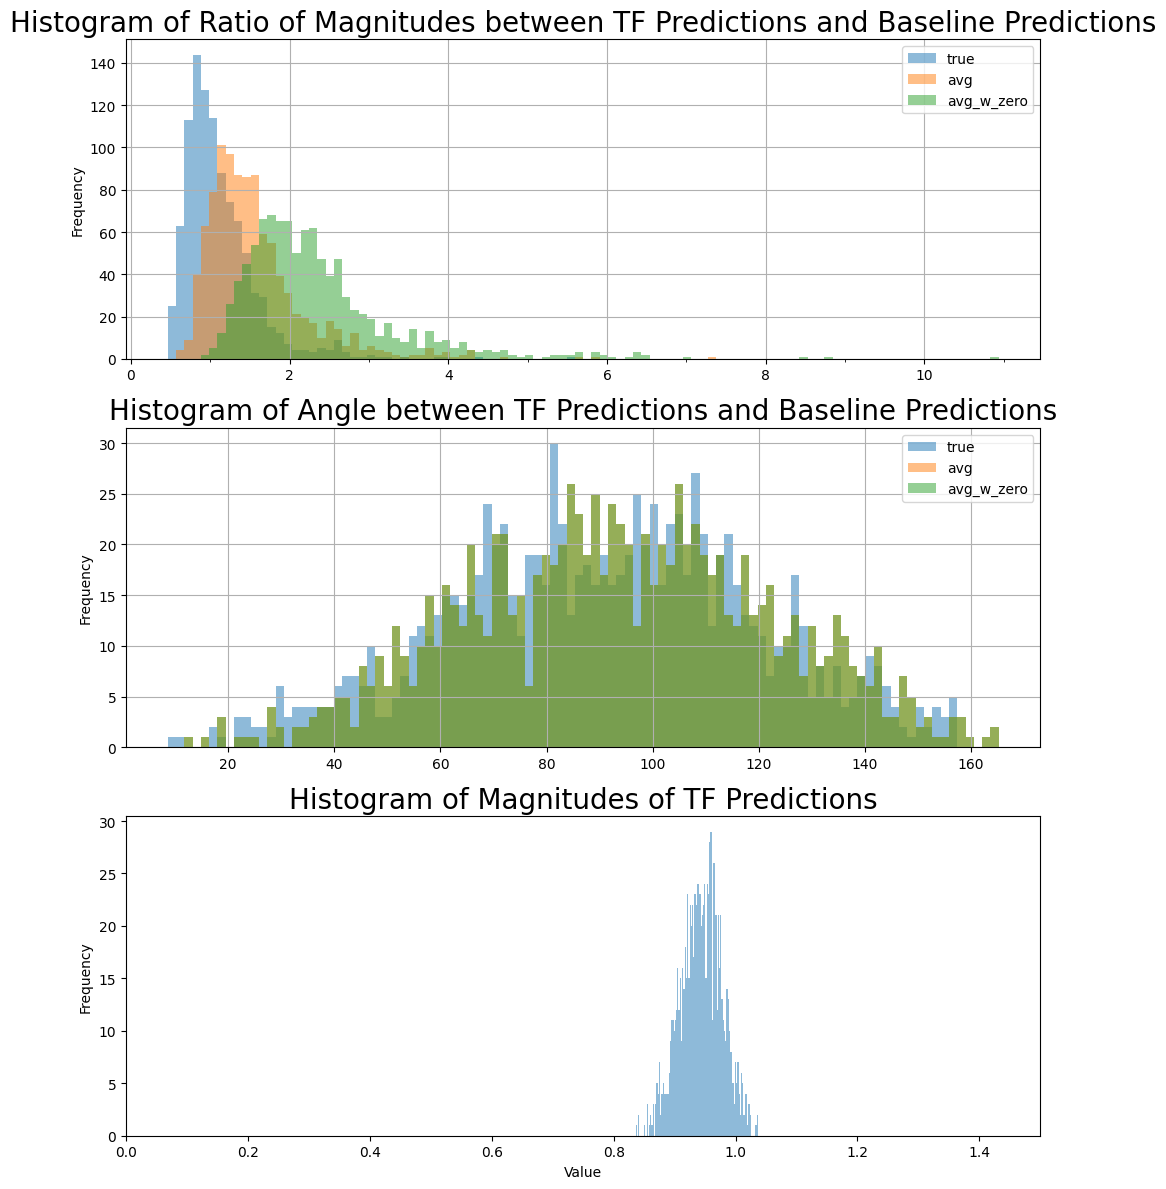




BLOCK 3



transformer_1af [[ 0.45667738  0.14412051 -0.41549736  0.3097607  -0.34824178]
 [ 0.34628558  0.13807164 -0.35281637  0.38659364 -0.42280632]
 [ 0.5411717   0.15625098 -0.36421305  0.3885162  -0.3623755 ]
 ...
 [ 0.3475975   0.10263056 -0.30568537  0.30623734 -0.44264042]
 [ 0.48531795  0.12967184 -0.3937593   0.25437632 -0.43898416]
 [ 0.29648522  0.11505472 -0.37025622  0.27511367 -0.40921447]]


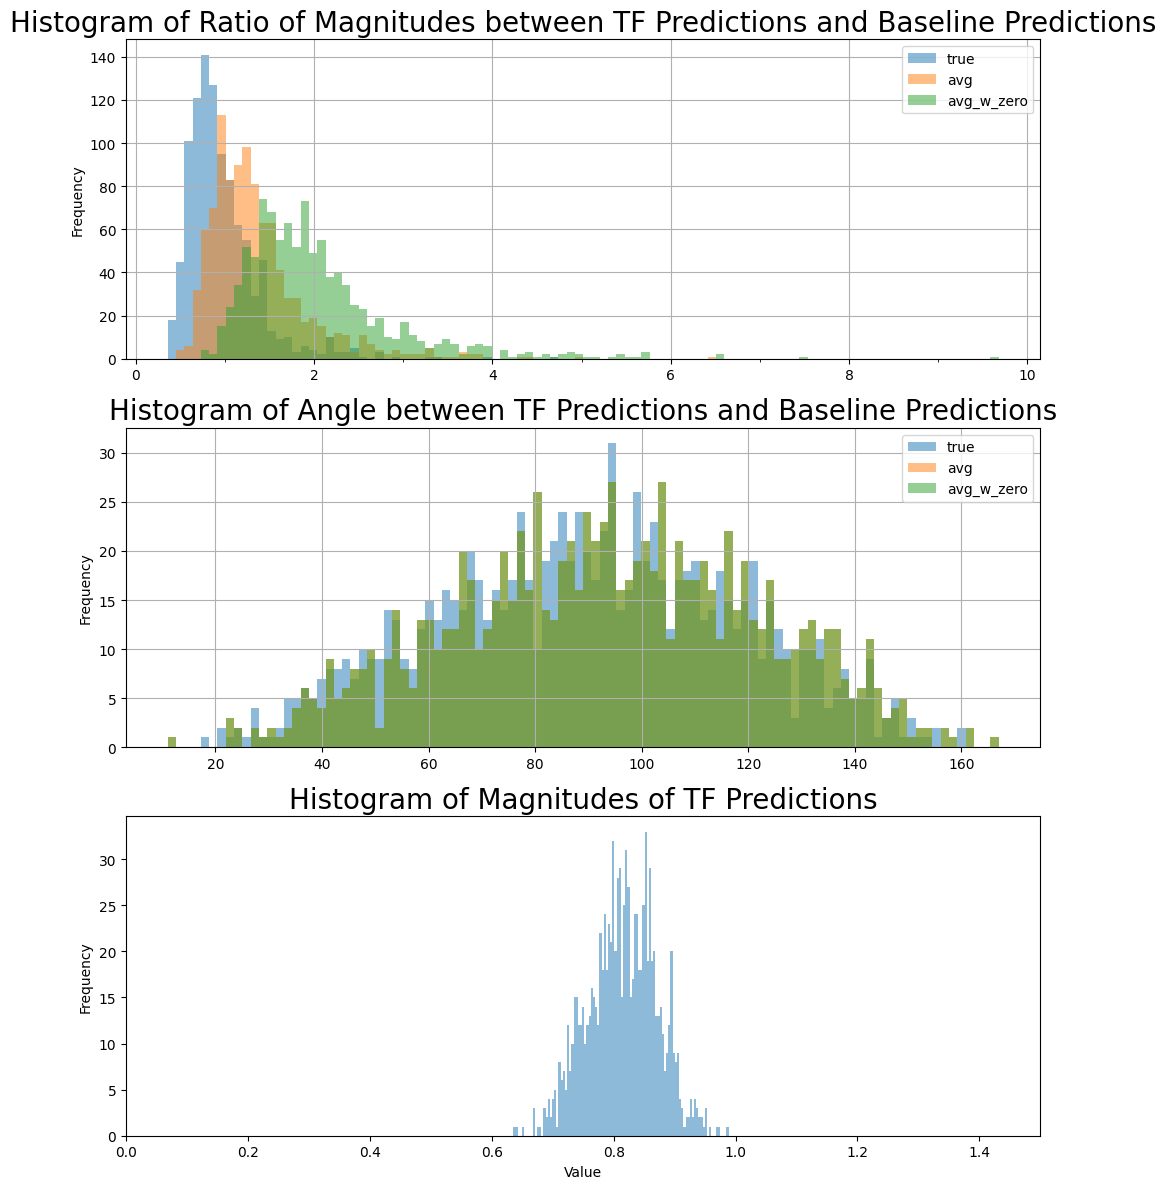




BLOCK 4



transformer_1af [[ 0.4545274   0.08138649 -0.24113336  0.04976323 -0.23593894]
 [ 0.27679902  0.25576663 -0.24960355  0.42539343 -0.40461284]
 [ 0.50895643  0.13065697 -0.34835628  0.26383027 -0.31240904]
 ...
 [-0.01074621  0.10518691 -0.22942033  0.13110426 -0.3185833 ]
 [ 0.31838816  0.23737803 -0.17757645  0.05646314 -0.36088234]
 [ 0.13879342 -0.05735073 -0.21627691  0.2363048  -0.22068968]]


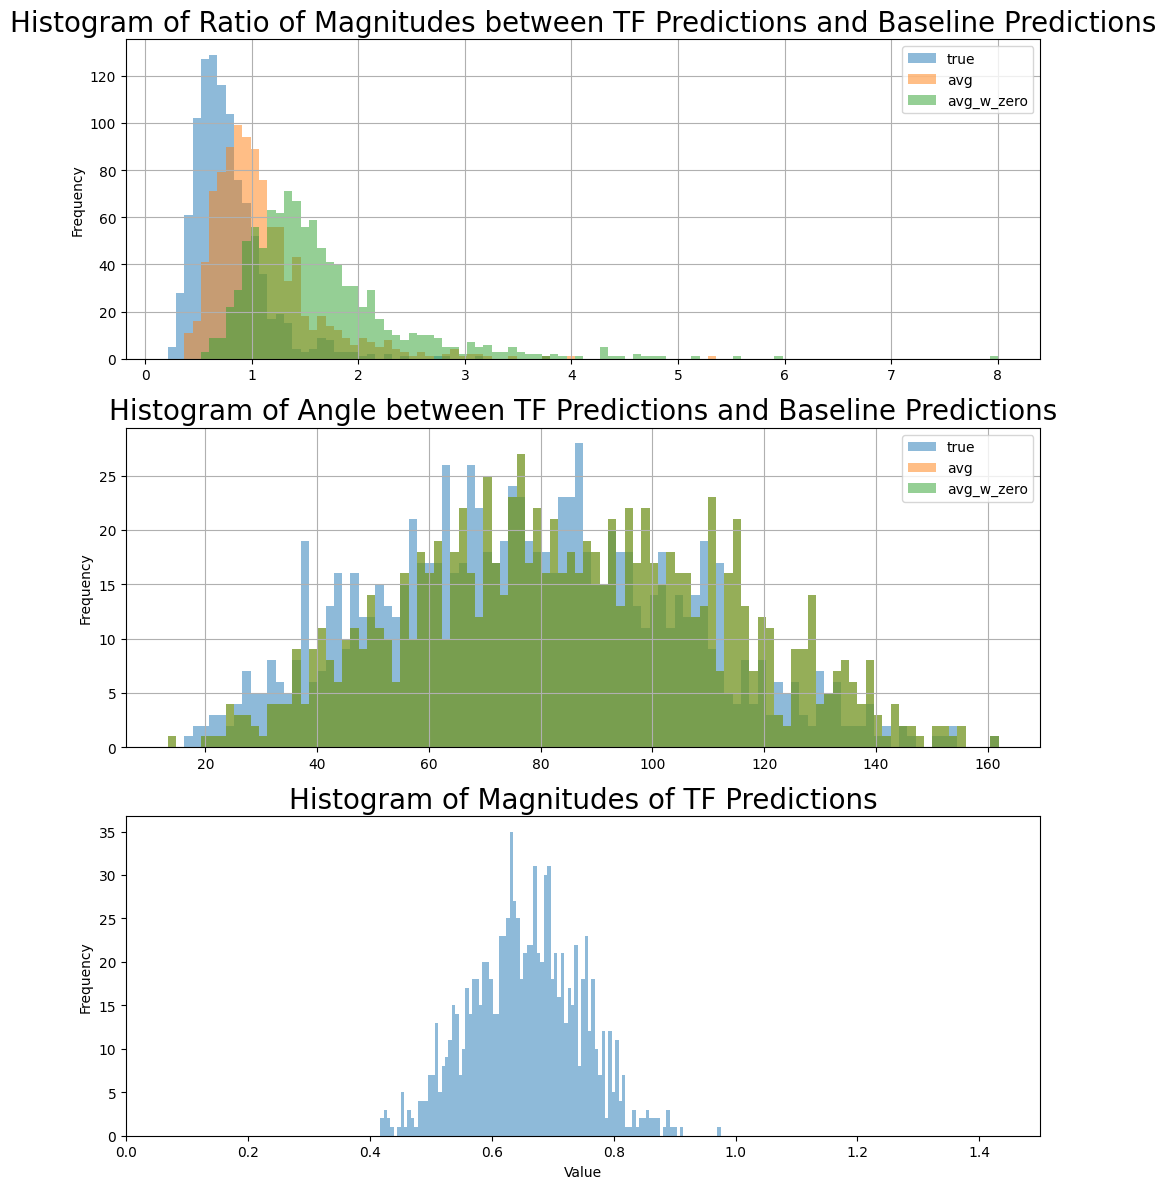




BLOCK 5



transformer_1af [[ 0.20975941  0.04360289 -0.11169443 -0.10259615  0.04520231]
 [ 0.01771058  0.34188387 -0.19932203  0.45290893 -0.22478777]
 [ 0.28960252  0.1207982  -0.32520753  0.19830662 -0.08270183]
 ...
 [-0.49133277  0.14997688 -0.21788357  0.02847051 -0.10845387]
 [-0.00571522  0.3657711  -0.02338915 -0.09449153 -0.10794809]
 [-0.23411687 -0.20635706 -0.12555483  0.2447569   0.09062004]]


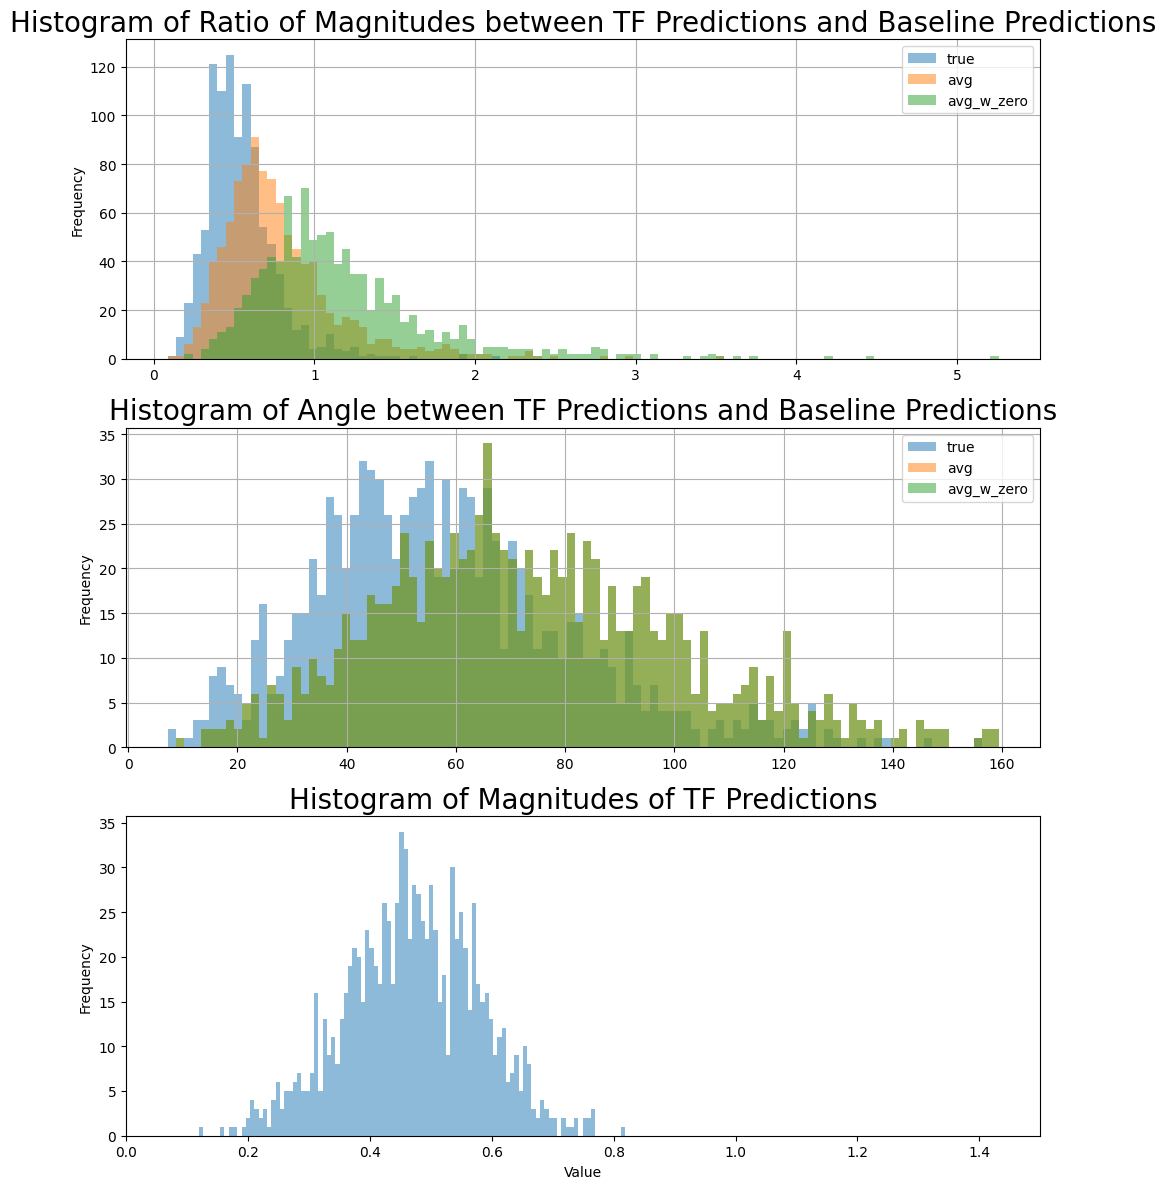




BLOCK 6



transformer_1af [[ 0.04274413  0.04274965 -0.04370184 -0.11787811  0.2060737 ]
 [-0.08893195  0.39221352 -0.1432009   0.540485   -0.15961379]
 [ 0.14925835  0.11843082 -0.3137815   0.19140801  0.03520399]
 ...
 [-0.6646112   0.14106703 -0.1913906  -0.01446475 -0.02384651]
 [-0.15961635  0.38132304  0.08720265 -0.13779014  0.01725107]
 [-0.4129902  -0.22652309 -0.04013578  0.32053763  0.2726348 ]]


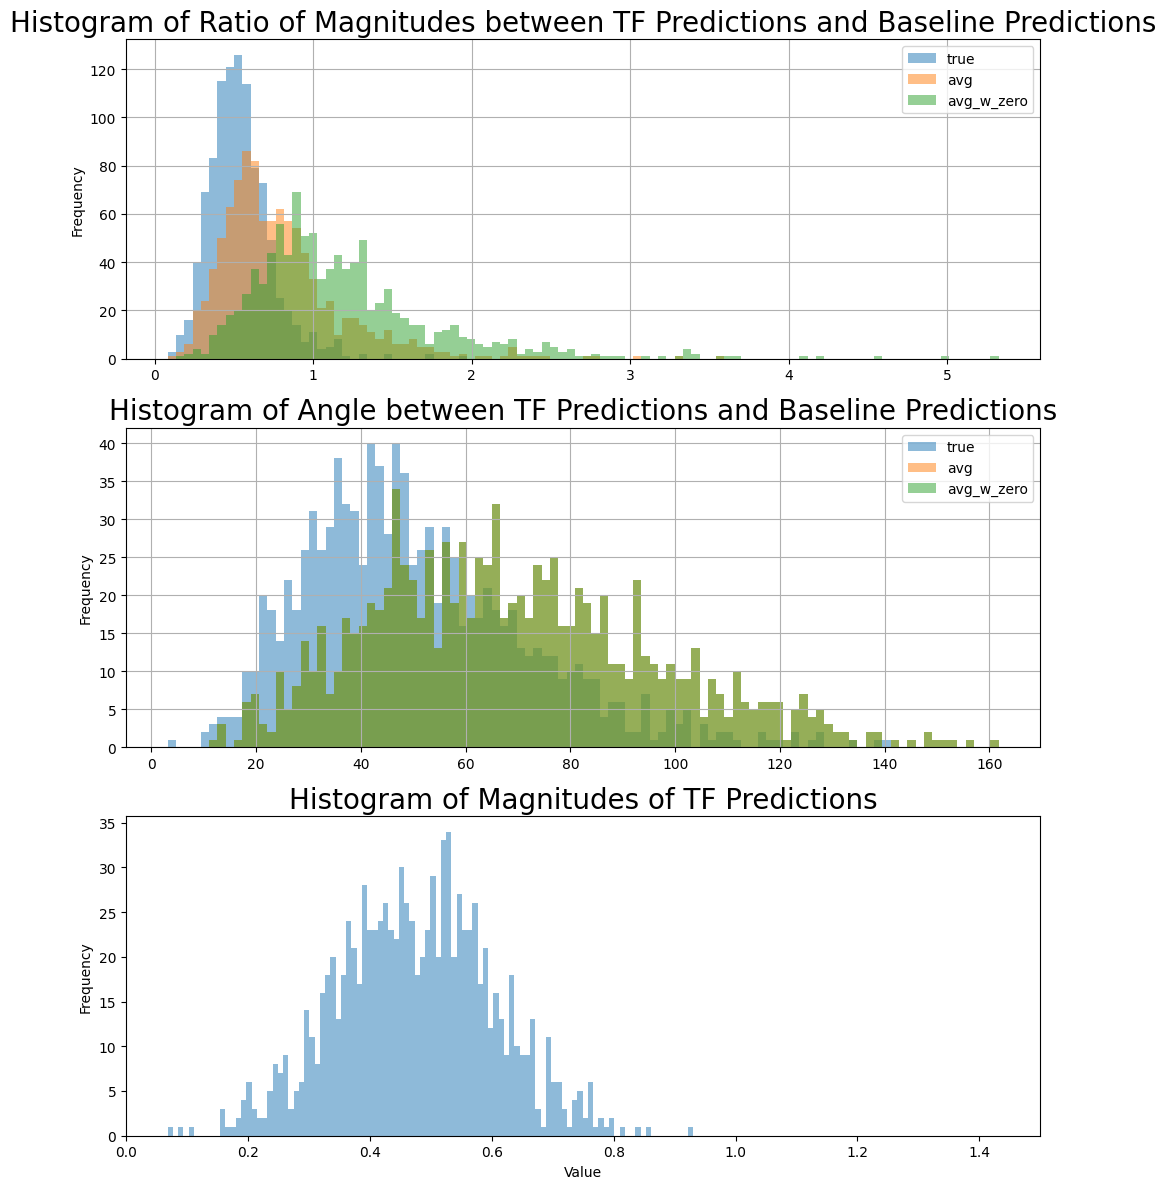




BLOCK 7



transformer_1af [[ 0.05635497 -0.0794163   0.03707415 -0.32691872  0.1842275 ]
 [-0.07076572  0.35511172 -0.11991622  0.42112458 -0.22997615]
 [ 0.15046278  0.02931935 -0.26815122  0.01257694 -0.03815964]
 ...
 [-0.7740827   0.05825454 -0.15360948 -0.2132083  -0.11396834]
 [-0.184858    0.32888806  0.16567463 -0.34595722 -0.07309324]
 [-0.4260574  -0.3673521  -0.0077564   0.196935    0.31054264]]


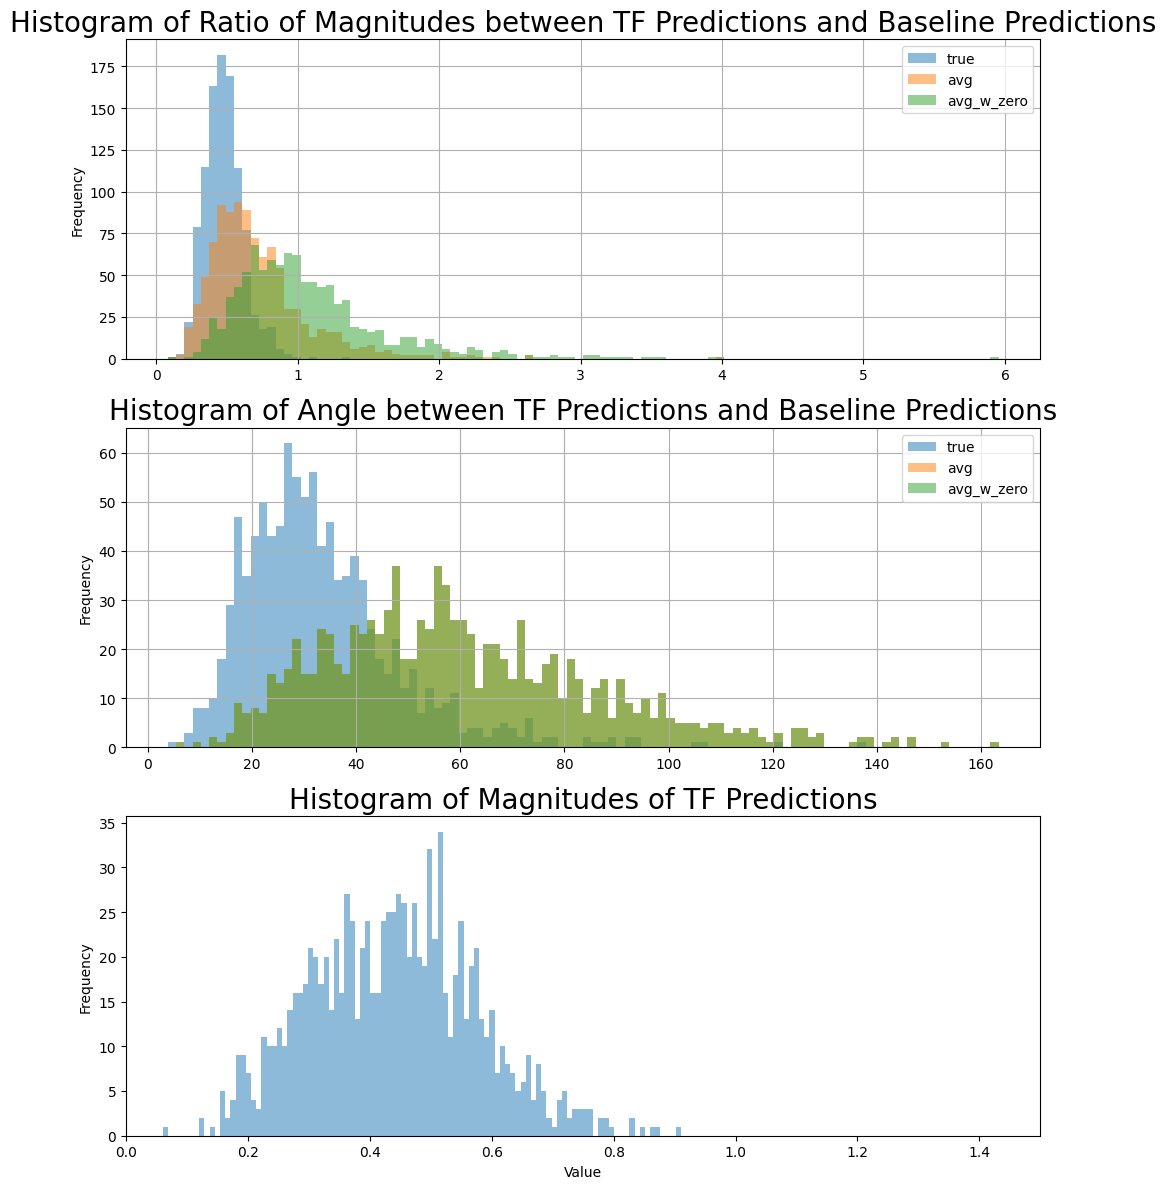




BLOCK 8



transformer_1af [[ 1.43065512e-01 -1.26184210e-01  6.40686601e-04 -4.72242355e-01
   2.83773750e-01]
 [-3.08199227e-02  4.33675468e-01 -2.10102081e-01  4.46119130e-01
  -2.33338803e-01]
 [ 1.83046579e-01  2.76160240e-02 -3.80120993e-01 -3.45916823e-02
   1.58533454e-03]
 ...
 [-8.94225836e-01  6.41738176e-02 -3.74024987e-01 -2.99395621e-01
  -1.02760375e-01]
 [-1.65544212e-01  3.75555038e-01  1.01214692e-01 -4.76760656e-01
  -3.60200703e-02]
 [-4.15208459e-01 -4.68582422e-01 -7.75733143e-02  2.23669916e-01
   4.01447445e-01]]


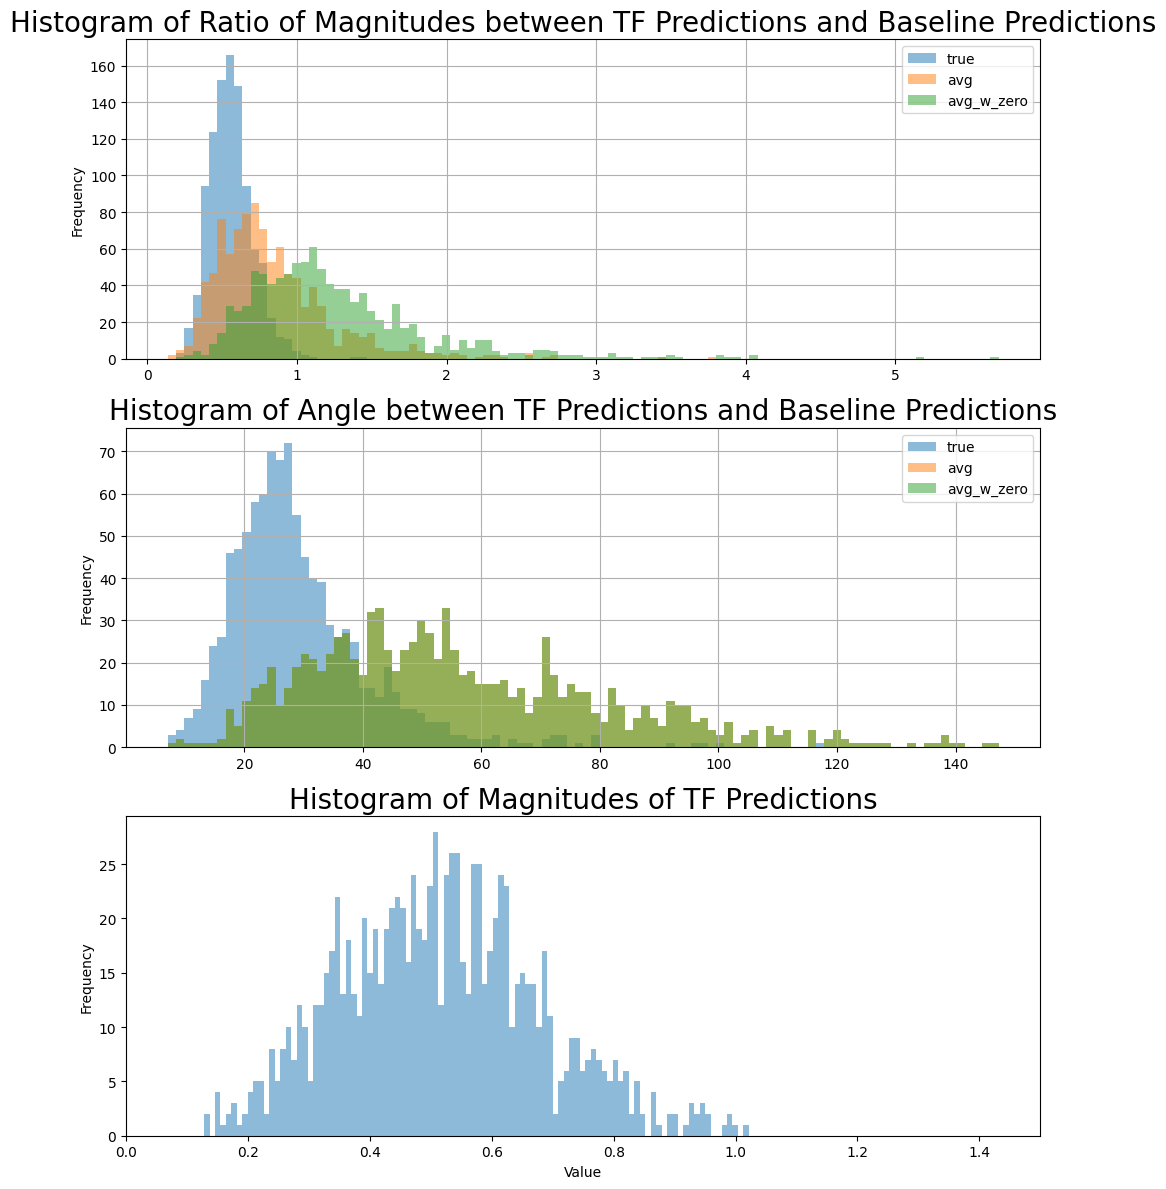




BLOCK 9



transformer_1af [[ 0.11727482 -0.137728    0.17213398 -0.5217947   0.4872809 ]
 [-0.01463276  0.55136317 -0.07637478  0.5736309  -0.1750176 ]
 [ 0.21127486  0.05808997 -0.26413602  0.00647293  0.1513196 ]
 ...
 [-1.0657518   0.1052442  -0.380298   -0.3025432  -0.01882154]
 [-0.26361072  0.51271856  0.22675374 -0.5162786   0.03419223]
 [-0.51034427 -0.5417661   0.07928113  0.35611832  0.6451212 ]]


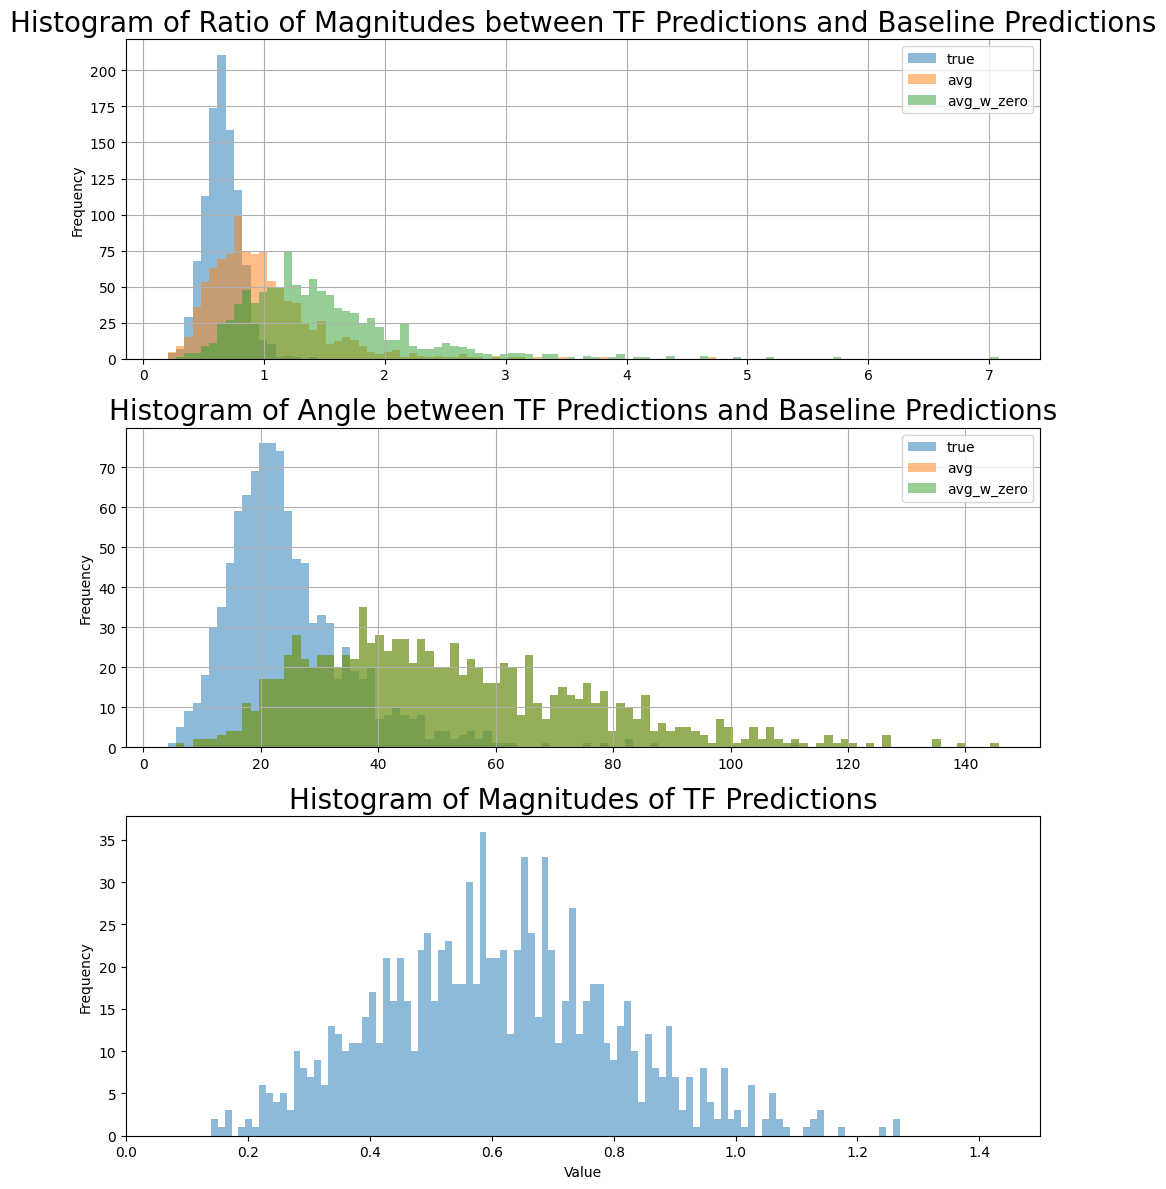




BLOCK 10



transformer_1af [[ 0.22097853 -0.31763214  0.2536561  -0.785779    0.49530277]
 [ 0.0976408   0.5089377  -0.08340956  0.51995146 -0.33322367]
 [ 0.32852495 -0.06839709 -0.31927097 -0.11188994  0.11519   ]
 ...
 [-1.2338867  -0.00706065 -0.42643657 -0.45273715 -0.0987632 ]
 [-0.2573663   0.4507073   0.33327267 -0.77890086 -0.02248892]
 [-0.48819363 -0.72747993  0.12435217  0.27694476  0.6748696 ]]


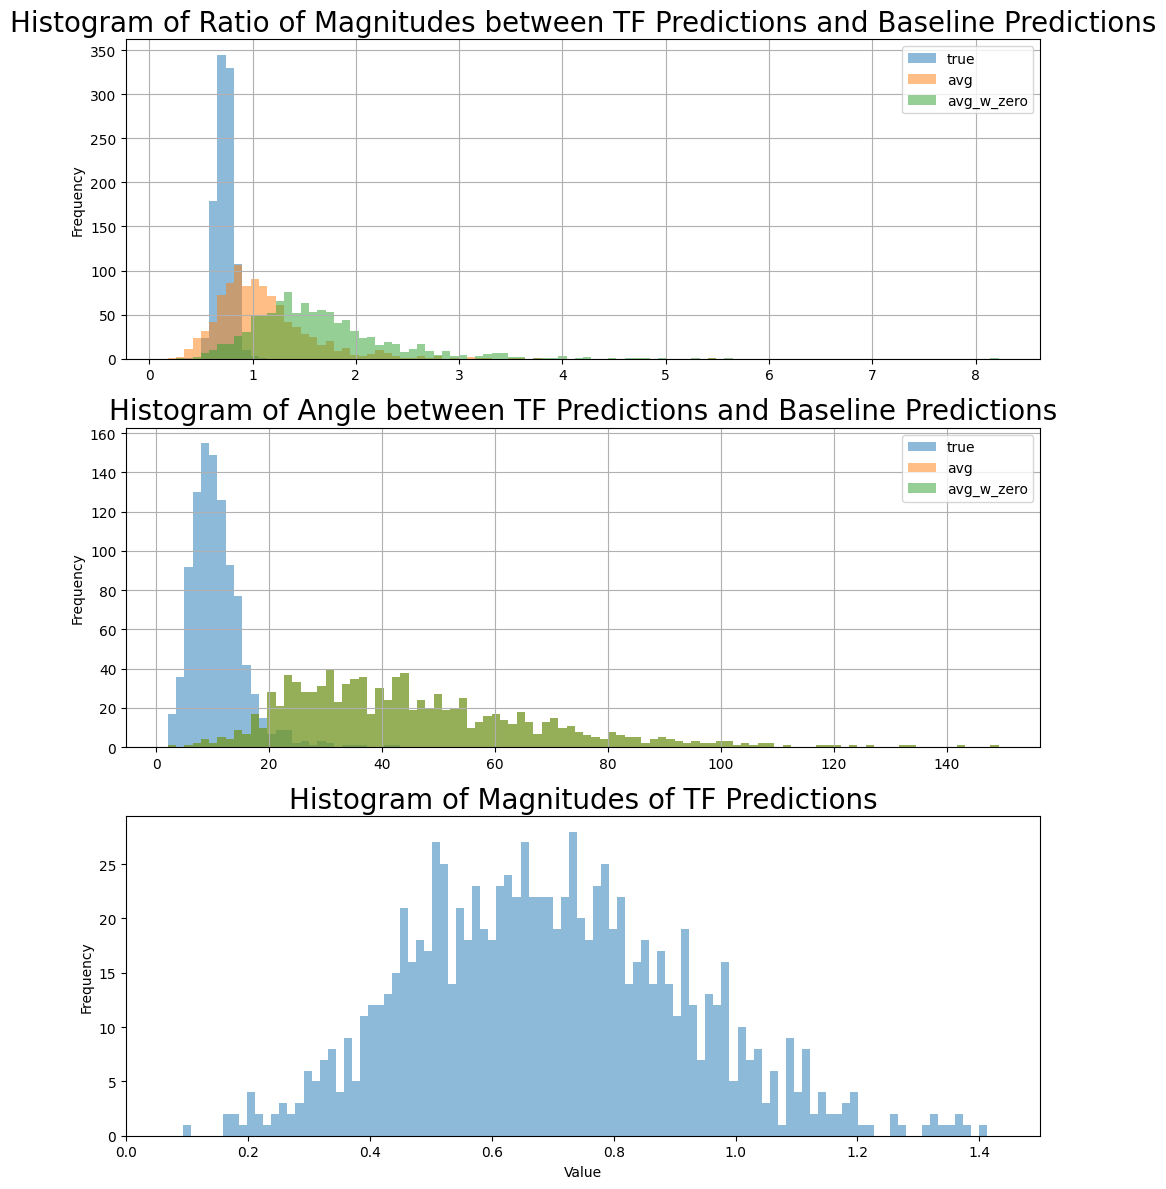




BLOCK 11



transformer_1af [[ 0.26747498 -0.41839772  0.30619374 -0.9706967   0.6251347 ]
 [ 0.11291729  0.5896584  -0.01573375  0.5414289  -0.2986415 ]
 [ 0.371421   -0.13561805 -0.3289352  -0.19190052  0.25248832]
 ...
 [-1.5002531  -0.07795604 -0.540862   -0.59015065 -0.08856785]
 [-0.2871086   0.5425562   0.40849847 -0.93889356  0.01125669]
 [-0.5665199  -0.91885597  0.1450975   0.2703067   0.8340314 ]]


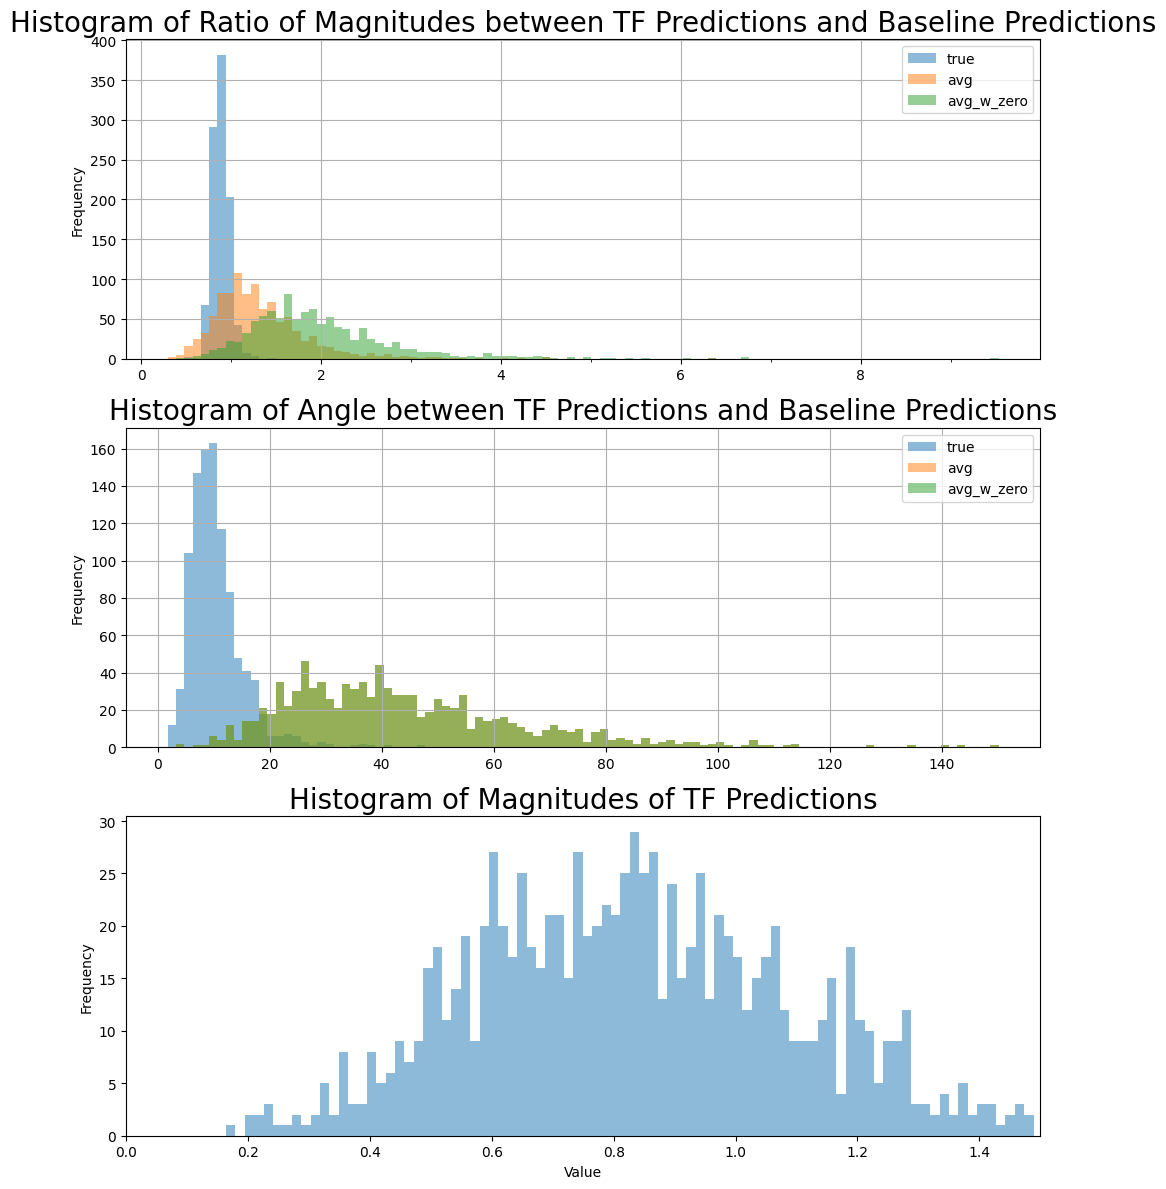




BLOCK 12



transformer_1af [[ 0.37827402 -0.51521105  0.34092656 -0.9895312   0.6906547 ]
 [ 0.27556965  0.6829267  -0.09392503  0.7446358  -0.33347693]
 [ 0.53094894 -0.19103532 -0.42651257 -0.1113665   0.2771284 ]
 ...
 [-1.7263813  -0.15235096 -0.63314354 -0.5173452  -0.13880059]
 [-0.26382756  0.5955502   0.4709933  -0.90806204 -0.00819665]
 [-0.5493157  -1.0249468   0.14604205  0.43880904  0.97821903]]


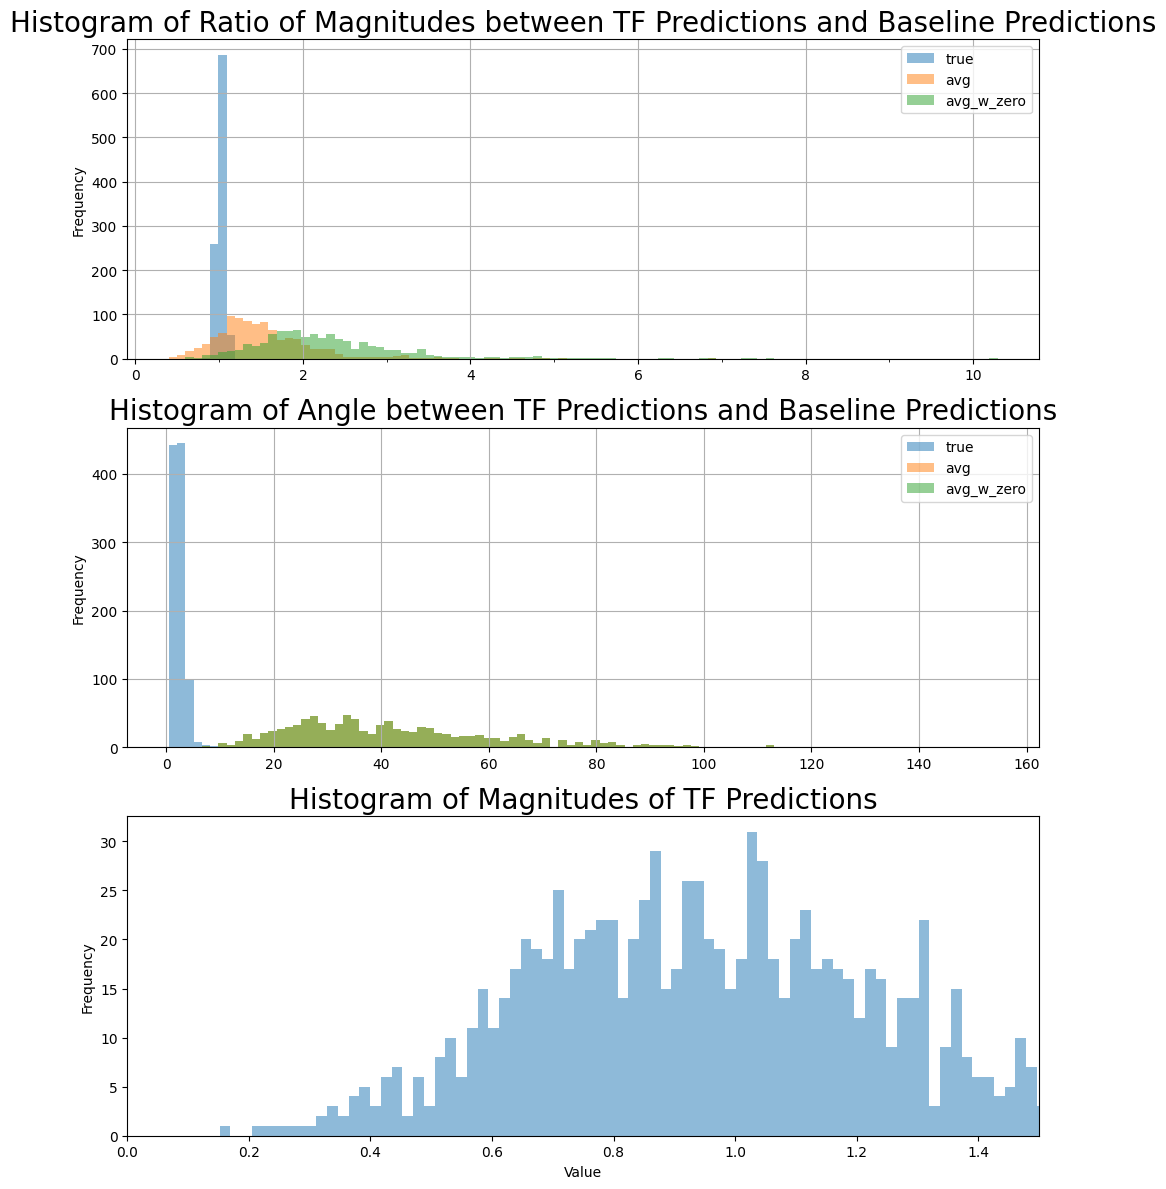

In [51]:
trace_config = 0

for block_idx in range(len(lenses)):


    print(f"\n\n\nBLOCK {block_idx}\n\n\n")

    q_ind = seg_starts_per_config[trace_config][-1] + 1
    # print(f"preds_tf_ebonye: {preds_tf_ebonye[trace_config,:,q_ind,:]}")
    preds_tf_block = lenses[block_idx]
    # print(f"preds_tf_block: {preds_tf_block[trace_config,:,q_ind,:]}")
    tf1af, true1af, avg1af, avg_w_zero1af = getMats(trace_config, seg_starts_per_config, multi_sys_ys, preds_tf_block)
    # print(f"preds_tf_block.shape: {preds_tf_block.shape}")
    # print(f"tf1af.shape: {tf1af.shape}")
    # print(f"true1af.shape: {true1af.shape}")
    # print(f"avg1af.shape: {avg1af.shape}")
    mags, angs = getSims(tf1af, true1af, avg1af, avg_w_zero1af)


    #### histogram

    # adjust for number of bins, same for all plots
    num_bins = 100

    # convert angs to degrees ranging from 0 to 180
    for key in angs:
        cosvals = angs[key]
        angs[key] = np.arccos(cosvals)*180/np.pi

    plot_path = f"../../../outputs/interp/black_box/plots/{model_name}/logit_lens/"

    inserted_payload=None

    os.makedirs(plot_path, exist_ok=True)



    # Histogram for Magnitudes
    fig, axs = plt.subplots(3, 1, figsize=(10, 12))

    mags_all = np.concatenate([
        mags["true"], 
        mags["avg"], 
        mags["avg_w_zero"]
    ])
    if inserted_payload is not None:
        mags_all = np.concatenate([
            mags_all, 
            mags["payload"]
        ])
    mags_edges = np.histogram_bin_edges(mags_all, bins=num_bins)

    axs[0].hist(mags["true"], bins=mags_edges, alpha=0.5, label='true')
    axs[0].hist(mags["avg"], bins=mags_edges, alpha=0.5, label='avg')
    axs[0].hist(mags["avg_w_zero"], bins=mags_edges, alpha=0.5, label='avg_w_zero')
    if inserted_payload is not None:
        axs[0].hist(mags["payload"], bins=mags_edges, alpha=0.5, label=payload_experiment)

    #axs[0].set_xlabel('Value')
    axs[0].set_ylabel('Frequency')
    axs[0].set_title('Histogram of Ratio of Magnitudes between TF Predictions and Baseline Predictions')
    axs[0].legend()
    axs[0].grid(True)
    # set minor ticks of interval 1
    axs[0].xaxis.set_minor_locator(plt.MultipleLocator(1))
    #fig.tight_layout()
    #plt.show()
    # fig.savefig(f"{plot_path}hist_mags_ckpt_{ckpt_step}_{payload_experiment}.pdf", bbox_inches='tight', format='pdf')

    # Histogram for Angles
    #fig, ax = plt.subplots(figsize=(10, 5))

    angs_all = np.concatenate([
        angs["true"], 
        angs["avg"], 
        angs["avg_w_zero"]
    ])
    if inserted_payload is not None:
        angs_all = np.concatenate([
            angs_all, 
            angs["payload"]
        ])
    angs_edges = np.histogram_bin_edges(angs_all, bins=num_bins)

    axs[1].hist(angs["true"], bins=angs_edges, alpha=0.5, label='true')
    axs[1].hist(angs["avg"], bins=angs_edges, alpha=0.5, label='avg')
    axs[1].hist(angs["avg_w_zero"], bins=angs_edges, alpha=0.5, label='avg_w_zero')
    if inserted_payload is not None:
        axs[1].hist(angs["payload"], bins=angs_edges, alpha=0.5, label=payload_experiment)

    #axs[1].set_xlabel('Value')
    axs[1].set_ylabel('Frequency')
    axs[1].set_title('Histogram of Angle between TF Predictions and Baseline Predictions')
    axs[1].legend()
    axs[1].grid(True)
    #plt.show()
    # fig.savefig(f"{plot_path}hist_angles_ckpt_{ckpt_step}_{payload_experiment}.pdf", bbox_inches='tight', format='pdf')

    # Histogram for tf magnitudes
    #fig, axs = plt.subplots(figsize=(10, 5))
    axs[2].hist(np.linalg.norm(tf1af, axis=1), bins=num_bins, alpha=0.5, label='tf mag')

    axs[2].set_xlabel('Value')
    axs[2].set_ylabel('Frequency')
    axs[2].set_xlim(0, 1.5)
    axs[2].set_title("Histogram of Magnitudes of TF Predictions")

    fig.tight_layout()
    plt.show()
    fig.savefig(f"{plot_path}hist_ckpt_{ckpt_step}_block_{block_idx}.pdf", bbox_inches = 'tight', format = 'pdf')

transformer_1af [[ 0.02749229 -0.23673032  0.01120722 -0.21270268  0.1608924 ]
 [ 0.07985578  0.02550378 -0.12242883  0.06659247 -0.04069895]
 [-0.04805313 -0.20763505 -0.12300236 -0.05273081  0.2873314 ]
 ...
 [-0.33185628 -0.09339467 -0.30114615 -0.20861286  0.06779858]
 [-0.10387933  0.25844008 -0.0353702  -0.03710325  0.01019925]
 [-0.00470144 -0.28903782 -0.07527537  0.07341996  0.14222029]]


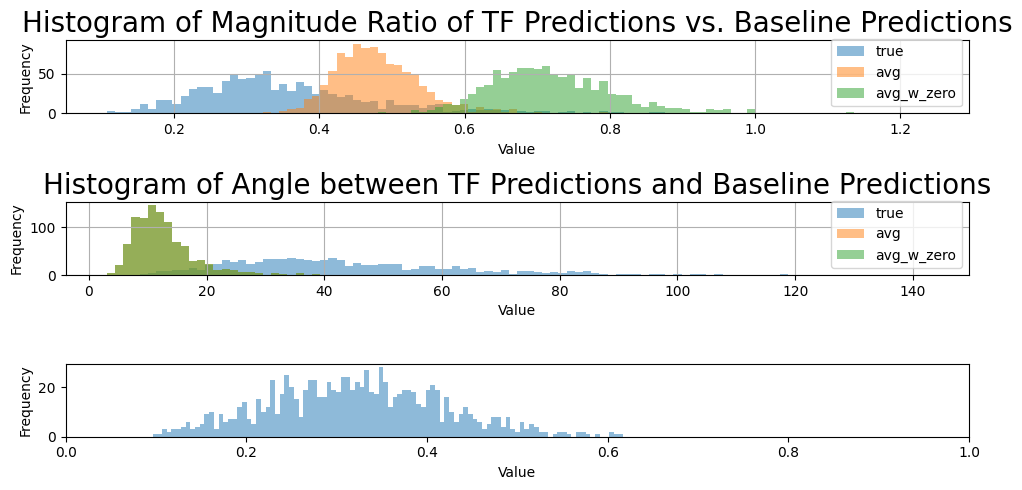

In [ ]:
#### histogram

# adjust for number of bins, same for all plots
num_bins = 100

#### data is in a 10000 x 5 matrix, each column is a different state variable
dummy_tf = np.random.rand(1000)
dummy_avg = np.random.rand(1000)
dummy_zero = np.random.rand(1000)

mags, angs = getSims(tf1af, true1af, avg1af, avg_w_zero1af, inserted_payload)

# convert angs to degrees ranging from 0 to 180
for key in angs:
    cosvals = angs[key]
    angs[key] = np.arccos(cosvals)*180/np.pi

plot_path = f"../../../outputs/interp/black_box/plots/{model_name}/"

inserted_payload=None

os.makedirs(plot_path, exist_ok=True)



# Histogram for Magnitudes
fig, (ax_mag, ax_ang, ax_tfmag) = plt.subplots(3,1, figsize=(10, 5))
#fig, ax = plt.subplots(figsize=(10, 5))

mags_all = np.concatenate([
    mags["true"], 
    mags["avg"], 
    mags["avg_w_zero"]
])
if inserted_payload is not None:
    mags_all = np.concatenate([
        mags_all, 
        mags["payload"]
    ])
mags_edges = np.histogram_bin_edges(mags_all, bins=num_bins)

ax_mag.hist(mags["true"], bins=mags_edges, alpha=0.5, label='true')
ax_mag.hist(mags["avg"], bins=mags_edges, alpha=0.5, label='avg')
ax_mag.hist(mags["avg_w_zero"], bins=mags_edges, alpha=0.5, label='avg_w_zero')
if inserted_payload is not None:
    ax.hist(mags["payload"], bins=mags_edges, alpha=0.5, label=payload_experiment)

ax_mag.set_xlabel('Value')
ax_mag.set_ylabel('Frequency')
ax_mag.set_title('Histogram of Magnitude Ratio of TF Predictions vs. Baseline Predictions')
ax_mag.legend()
ax_mag.grid(True)
# set minor ticks of interval 1
ax_mag.xaxis.set_minor_locator(plt.MultipleLocator(1))
#fig.tight_layout()
#plt.show()
#fig.savefig(f"{plot_path}hist_mags_ckpt_{ckpt_step}_{payload_experiment}.pdf", bbox_inches='tight', format='pdf')

# Histogram for Angles
#fig, ax = plt.subplots(3, 1, figsize=(10, 5))

angs_all = np.concatenate([
    angs["true"], 
    angs["avg"], 
    angs["avg_w_zero"]
])
if inserted_payload is not None:
    angs_all = np.concatenate([
        angs_all, 
        angs["payload"]
    ])
angs_edges = np.histogram_bin_edges(angs_all, bins=num_bins)

ax_ang.hist(angs["true"], bins=angs_edges, alpha=0.5, label='true')
ax_ang.hist(angs["avg"], bins=angs_edges, alpha=0.5, label='avg')
ax_ang.hist(angs["avg_w_zero"], bins=angs_edges, alpha=0.5, label='avg_w_zero')
if inserted_payload is not None:
    ax_ang.hist(angs["payload"], bins=angs_edges, alpha=0.5, label=payload_experiment)

ax_ang.set_xlabel('Value')
ax_ang.set_ylabel('Frequency')
ax_ang.set_title('Histogram of Angle between TF Predictions and Baseline Predictions')
ax_ang.legend()
ax_ang.grid(True)
#plt.show()
#fig.savefig(f"{plot_path}hist_angles_ckpt_{ckpt_step}_{payload_experiment}.pdf", bbox_inches='tight', format='pdf')

# Histogram for tf magnitudes
#fig, ax = plt.subplots(figsize=(10, 5))
ax_tfmag.hist(np.linalg.norm(tf1af, axis=1), bins=num_bins, alpha=0.5, label='tf mag')

ax_tfmag.set_xlabel('Value')
ax_tfmag.set_ylabel('Frequency')
ax_tfmag.set_xlim(0, 1)

fig.tight_layout()
plt.show()

